## Прогнозирование стоимости автомобиля по характеристикам
У нас есть собранные условной компанией записи о продаже автомобилей и данные авто.ру. На данных с сайта мы тренируем модели, на тестовых данных проверяем результат обучения. Задача - как можно точнее предсказать цену машины.

# Загружаем нужные библиотеки

In [1]:
import requests as r
from bs4 import BeautifulSoup
import json
import time

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pandas import Series
import pandas_profiling

import matplotlib.pyplot as plt
import seaborn as sns

import sys
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm

from sklearn.ensemble import (AdaBoostClassifier, GradientBoostingClassifier,
                              RandomForestClassifier, ExtraTreesClassifier)
from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor

from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, PolynomialFeatures

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)

Python       : 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
Numpy        : 1.18.5


# Необходимые функции

In [4]:
'''Функция расчета точности модели (замечание: ее стоило бы называть "...неточности", чтобы не возникало вопросов)'''

def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [5]:
'''Простенькая функция для краткого описания признака'''

def sign_study(column):
    print(df[column].value_counts())
    print(df[column].isna().sum())

In [6]:
'''Функция для перевода числовых значений в категориальные'''

def sign_to_cat(column):
    if column <= perc25:
        column = '0'
        return column             
    if perc25 < column <= perc50:
        column = '1'
        return column
    if perc50 < column <= perc75:
        column = '2'
        return column
    if column > perc75:
        column = '3'
        return column

# Setup

In [7]:
VERSION    = 16
# DIR_TRAIN  = '../input/parsing-all-moscow-auto-ru-09-09-2020/' # подключил к ноутбуку внешний датасет
DIR_TEST   = '../input/sf-dst-car-price-prediction/'
VAL_SIZE   = 0.20   # 20%

# Data

In [8]:
!ls '../input'

autoru-18-07-2021	 parsing-all-moscow-auto-ru-09-09-2020
autoru-cars-dataset	 sf-dst-car-price-prediction
autoru-parsed-0603-1304


**Подключаем датасеты: тренировочный и тестовый.**

К сожалению, времени на разработку парсинга не хватило, поэтому взяла готовый из самых свежих.

In [9]:
# train = pd.read_csv('../input/autoru-parsed-0603-1304/new_data_99_06_03_13_04.csv') # датасет для обучения модели
# train = pd.read_csv('../input/autoru-cars-dataset/autoru_cars_dataset.csv')
train = pd.read_csv('../input/autoru-18-07-2021/all_auto_ru.csv')
test = pd.read_csv(DIR_TEST+'test.csv')
sample_submission = pd.read_csv(DIR_TEST+'sample_submission.csv')

**Первичное исследование train**

In [10]:
train.head(5)

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,engineDisplacement,enginePower,description,mileage,Комплектация,Привод,Руль,Состояние,Владельцы,ПТС,Таможня,Владение,price,start_date,hidden,model
0,Седан,AUDI,040001,бензин,1990,2.3 MT (133 л.с.),4,1991,SEDAN MECHANICAL 2.3,MECHANICAL,2.3,133,"Перед тем как звонить,дочитайте до конца.\nМаш...",326000,{'id': '0'},передний,LEFT,NaN,3.0,ORIGINAL,True,"{'year': 2020, 'month': 5}",150000.0,2020-11-08T17:23:26Z,NaN,100
1,Седан,AUDI,040001,бензин,1990,2.3 MT (133 л.с.),4,1994,SEDAN MECHANICAL 2.3,MECHANICAL,2.3,133,"Машина в хорошем состоянии, все вопросы у капота.",219000,{'id': '0'},передний,LEFT,NaN,4.0,ORIGINAL,True,NaN,120000.0,2021-07-05T12:04:53Z,NaN,100
2,Седан,AUDI,007F00,бензин,1990,2.6 AT (150 л.с.),4,1993,SEDAN AUTOMATIC 2.6,AUTOMATIC,2.6,150,"Автомобиль в хорошем состоянии. птс оригинал, ...",406000,{'id': '0'},передний,LEFT,NaN,4.0,ORIGINAL,True,NaN,165000.0,2021-06-26T14:51:28Z,NaN,100
3,Седан,AUDI,EE1D19,бензин,1990,2.3 AT (133 л.с.),4,1991,SEDAN AUTOMATIC 2.3,AUTOMATIC,2.3,133,Проблема в коробке торг обмен на ваз,399000,{'id': '0'},передний,LEFT,NaN,4.0,ORIGINAL,True,NaN,75000.0,2021-07-17T16:17:01Z,NaN,100
4,Седан,AUDI,97948F,бензин,1990,2.3 MT (133 л.с.),4,1991,SEDAN MECHANICAL 2.3,MECHANICAL,2.3,133,В РОЛЬФ Юг | Автомобили с пробегом только самы...,385341,{'id': '0'},передний,LEFT,NaN,4.0,ORIGINAL,True,NaN,153000.0,2021-07-08T03:45:27Z,NaN,100


In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88509 entries, 0 to 88508
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              88509 non-null  object 
 1   brand                 88509 non-null  object 
 2   color                 88509 non-null  object 
 3   fuelType              88509 non-null  object 
 4   modelDate             88509 non-null  int64  
 5   name                  88509 non-null  object 
 6   numberOfDoors         88509 non-null  int64  
 7   productionDate        88509 non-null  int64  
 8   vehicleConfiguration  88509 non-null  object 
 9   vehicleTransmission   88509 non-null  object 
 10  engineDisplacement    88509 non-null  object 
 11  enginePower           88509 non-null  int64  
 12  description           86236 non-null  object 
 13  mileage               88509 non-null  int64  
 14  Комплектация          88509 non-null  object 
 15  Привод             

In [12]:
# Удаляем строки с нулевой ценой
train = train.dropna(axis=0, subset=['price'])

In [13]:
train['price']

0         150000.0
1         120000.0
2         165000.0
3          75000.0
4         153000.0
           ...    
88504    1200000.0
88505    1159000.0
88506    1044000.0
88507    1050000.0
88508     888888.0
Name: price, Length: 88233, dtype: float64

In [14]:
len(train) - len(train.drop_duplicates())

3284

In [15]:
train = train.drop_duplicates()

In [16]:
print('Размерность тренировочного датасета: ', train.shape)
display(train.head(5))

Размерность тренировочного датасета:  (84949, 26)


,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,engineDisplacement,enginePower,description,mileage,Комплектация,Привод,Руль,Состояние,Владельцы,ПТС,Таможня,Владение,price,start_date,hidden,model
0,Седан,AUDI,040001,бензин,1990,2.3 MT (133 л.с.),4,1991,SEDAN MECHANICAL 2.3,MECHANICAL,2.3,133,"Перед тем как звонить,дочитайте до конца.\nМаш...",326000,{'id': '0'},передний,LEFT,NaN,3.0,ORIGINAL,True,"{'year': 2020, 'month': 5}",150000.0,2020-11-08T17:23:26Z,NaN,100
1,Седан,AUDI,040001,бензин,1990,2.3 MT (133 л.с.),4,1994,SEDAN MECHANICAL 2.3,MECHANICAL,2.3,133,"Машина в хорошем состоянии, все вопросы у капота.",219000,{'id': '0'},передний,LEFT,NaN,4.0,ORIGINAL,True,NaN,120000.0,2021-07-05T12:04:53Z,NaN,100
2,Седан,AUDI,007F00,бензин,1990,2.6 AT (150 л.с.),4,1993,SEDAN AUTOMATIC 2.6,AUTOMATIC,2.6,150,"Автомобиль в хорошем состоянии. птс оригинал, ...",406000,{'id': '0'},передний,LEFT,NaN,4.0,ORIGINAL,True,NaN,165000.0,2021-06-26T14:51:28Z,NaN,100
3,Седан,AUDI,EE1D19,бензин,1990,2.3 AT (133 л.с.),4,1991,SEDAN AUTOMATIC 2.3,AUTOMATIC,2.3,133,Проблема в коробке торг обмен на ваз,399000,{'id': '0'},передний,LEFT,NaN,4.0,ORIGINAL,True,NaN,75000.0,2021-07-17T16:17:01Z,NaN,100
4,Седан,AUDI,97948F,бензин,1990,2.3 MT (133 л.с.),4,1991,SEDAN MECHANICAL 2.3,MECHANICAL,2.3,133,В РОЛЬФ Юг | Автомобили с пробегом только самы...,385341,{'id': '0'},передний,LEFT,NaN,4.0,ORIGINAL,True,NaN,153000.0,2021-07-08T03:45:27Z,NaN,100


In [17]:
train['model']

0           100
1           100
2           100
3           100
4           100
          ...  
88504    RODIUS
88505    STAVIC
88506    STAVIC
88507    STAVIC
88508    STAVIC
Name: model, Length: 84949, dtype: object

In [18]:
train['model_name'] = train['model']

In [19]:
train = train.drop('model', axis = 1)

In [20]:
train.sample()

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,engineDisplacement,enginePower,description,mileage,Комплектация,Привод,Руль,Состояние,Владельцы,ПТС,Таможня,Владение,price,start_date,hidden,model_name
8137,Внедорожник 5 дв.,BMW,0000CC,дизель,2017,20d xDrive 2.0d AT (190 л.с.) 4WD,5,2021,ALLROAD_5_DOORS AUTOMATIC 20d,AUTOMATIC,20d,190,УСПЕЙТЕ ДО ПОВЫШЕНИЯ ЦЕН!\n\nПОКА ДРУГИЕ ДИКТУ...,0,"{'id': '21408288', 'name': 'xDrive20d M Sport'...",полный,LEFT,NaN,NaN,ORIGINAL,True,NaN,5538400.0,2021-06-09T08:44:49Z,NaN,X3


**Первичное исследование test**

In [21]:
test.head(5)

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,NaN,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,74000,2013,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.2 AMT (105 л.с.),5,1603226273,RUB,2014,1100575026,"{""id"":""10373605"",""displacement"":1197,""engine_t...",LIFTBACK ROBOT 1.2,роботизированная,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,NaN,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,60563,2017,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.6 MT (110 л.с.),5,1603226277,RUB,2017,1100549428,"{""id"":""20913311"",""displacement"":1598,""engine_t...",LIFTBACK MECHANICAL 1.6,механическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
2,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/superb/11...,серый,"{""id"":""20026336"",""name"":""Ambition"",""available_...","Все автомобили, представленные в продаже, прох...",1.8 LTR,152 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,88000,2013,"{""code"":""SUPERB"",""name"":""Superb"",""ru_name"":""Су...",SUPERB,DSG 1.8 AMT (152 л.с.),5,1603226280,RUB,2014,1100658222,"{""id"":""20026323"",""nameplate"":""DSG"",""displaceme...",LIFTBACK ROBOT 1.8,роботизированная,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
3,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,коричневый,"{""id"":""20803582"",""name"":""Ambition"",""available_...",КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...,1.6 LTR,110 N12,"{""cruise-control"":true,""roller-blind-for-rear-...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,95000,2013,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.6 AT (110 л.с.),5,1603226284,RUB,2014,1100937408,"{""id"":""20105521"",""displacement"":1598,""engine_t...",LIFTBACK AUTOMATIC 1.6,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
4,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,белый,NaN,ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...,1.8 LTR,152 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,58536,2008,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.8 AT (152 л.с.),5,1603226288,RUB,2012,1101037972,"{""id"":""4561004"",""displacement"":1798,""engine_ty...",LIFTBACK AUTOMATIC 1.8,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен


In [22]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

In [23]:
# Обнуляем цену в тестовом датасете.

test['price'] = 0

In [24]:
print('Размерность тестового датасета: ', test.shape)
display(test.head(5))

Размерность тестового датасета:  (34686, 33)


,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня,price
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,NaN,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,74000,2013,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.2 AMT (105 л.с.),5,1603226273,RUB,2014,1100575026,"{""id"":""10373605"",""displacement"":1197,""engine_t...",LIFTBACK ROBOT 1.2,роботизированная,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,0
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,NaN,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,60563,2017,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.6 MT (110 л.с.),5,1603226277,RUB,2017,1100549428,"{""id"":""20913311"",""displacement"":1598,""engine_t...",LIFTBACK MECHANICAL 1.6,механическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,0
2,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/superb/11...,серый,"{""id"":""20026336"",""name"":""Ambition"",""available_...","Все автомобили, представленные в продаже, прох...",1.8 LTR,152 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,88000,2013,"{""code"":""SUPERB"",""name"":""Superb"",""ru_name"":""Су...",SUPERB,DSG 1.8 AMT (152 л.с.),5,1603226280,RUB,2014,1100658222,"{""id"":""20026323"",""nameplate"":""DSG"",""displaceme...",LIFTBACK ROBOT 1.8,роботизированная,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,0
3,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,коричневый,"{""id"":""20803582"",""name"":""Ambition"",""available_...",КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...,1.6 LTR,110 N12,"{""cruise-control"":true,""roller-blind-for-rear-...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,95000,2013,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.6 AT (110 л.с.),5,1603226284,RUB,2014,1100937408,"{""id"":""20105521"",""displacement"":1598,""engine_t...",LIFTBACK AUTOMATIC 1.6,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,0
4,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,белый,NaN,ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...,1.8 LTR,152 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,58536,2008,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.8 AT (152 л.с.),5,1603226288,RUB,2012,1101037972,"{""id"":""4561004"",""displacement"":1798,""engine_ty...",LIFTBACK AUTOMATIC 1.8,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,0


**Сравнение train и test**

In [25]:
#  Взяла у участников соревнования функцию по сравнению датасетов
def check_df_before_merg(d_df1,d_df2):
    
    list_of_names1 = list(d_df1.columns)
    temp_dict = {}
    temp_dict['feature_train'] = list_of_names1
    temp_dict['type_train'] = d_df1.dtypes
    temp_dict['sample_train'] = d_df1.loc[5].values
    temp_dict['# unique_train'] = d_df1.nunique().values
    temp_df1 = pd.DataFrame.from_dict(temp_dict)
    
    
    list_of_names2 = list(d_df2.columns)
    temp_dict2 = {}
    temp_dict2['feature_test'] = list_of_names2
    temp_dict2['type_test'] = d_df2.dtypes
    temp_dict2['sample_test'] = d_df2.loc[5].values
    temp_dict2['# unique_test'] = d_df2.nunique().values
    temp_df2 = pd.DataFrame.from_dict(temp_dict2)
    
    temp_insert = pd.DataFrame(columns=['< - >'])
    
    temp_df = pd.concat([temp_df1,temp_insert, temp_df2], axis=1, sort=False)
    temp_df.reset_index(inplace = True)
    del temp_df['index']
    temp_df['< - >'] = '| - |'
    display(temp_df)

    temp_dict3 = {}
    temp_df3= pd.DataFrame(temp_df)
    temp_list  = []
    temp_list2  = []
    temp_list3  = []
    temp_list4  = []
    temp_list5  = []

    for i in range(len(temp_df)):
        if str(temp_df3['type_train'][i]) != str(temp_df3['type_test'][i]):
            temp_list.append(temp_df3['feature_train'][i])
            temp_list2.append(temp_df3['feature_test'][i])
            temp_list3.append(str(temp_df3['type_train'][i]) + ' != ' + str(temp_df3['type_test'][i]))
            temp_list4.append(i)
        if temp_df3['# unique_test'][i]>0 and temp_df3['# unique_train'][i]/temp_df3['# unique_test'][i] > 2:
            temp_list5.append(i)
            
    temp_dict3['index']= temp_list4
    temp_dict3['feature_train']= temp_list
    temp_dict3['не совпадают типы'] = temp_list3
    temp_dict3['feature_test']= temp_list2

    temp_df4 = pd.DataFrame.from_dict(temp_dict3)
    temp_df4.set_index('index',inplace=True)

    print(f'Резюме:\n 1. Не совпали типы в:= {len(temp_df4)} столбцах\n')
    print(f'2. Уникальные значения различаются в:= {len(temp_list5)} столбцах {temp_list5}')
    display(temp_df4)

In [26]:
check_df_before_merg(train,test)

,feature_train,type_train,sample_train,# unique_train,< - >,feature_test,type_test,sample_test,# unique_test
0,bodyType,object,Седан,167.0,| - |,bodyType,object,лифтбек,24.0
1,brand,object,AUDI,36.0,| - |,brand,object,SKODA,12.0
2,color,object,FAFBFB,16.0,| - |,color,object,серый,16.0
3,fuelType,object,бензин,5.0,| - |,fuelType,object,бензин,5.0
4,modelDate,int64,1990,72.0,| - |,modelDate,int64,2008,66.0
5,name,object,2.3 AT (133 л.с.),4279.0,| - |,name,object,2.0 AMT (200 л.с.),2780.0
6,numberOfDoors,int64,4,4.0,| - |,numberOfDoors,int64,5,5.0
7,productionDate,int64,1992,72.0,| - |,productionDate,int64,2012,69.0
8,vehicleConfiguration,object,SEDAN AUTOMATIC 2.3,1774.0,| - |,vehicleConfiguration,object,LIFTBACK ROBOT 2.0,634.0
9,vehicleTransmission,object,AUTOMATIC,4.0,| - |,vehicleTransmission,object,роботизированная,4.0


Резюме:
 1. Не совпали типы в:= 18 столбцах

2. Уникальные значения различаются в:= 6 столбцах [0, 1, 8, 10, 12, 22]


,feature_train,не совпадают типы,feature_test
index,,,
11,enginePower,int64 != object,enginePower
14,Комплектация,object != nan,NaN
17,Состояние,float64 != object,Состояние
18,Владельцы,float64 != object,Владельцы
20,Таможня,bool != object,Таможня
22,price,float64 != int64,price
23,start_date,object != nan,NaN
24,hidden,float64 != nan,NaN
26,NaN,nan != object,car_url


Изучим признаки, которые у нас есть, более предметно. 

Выясняется, что часть колонок не совпадает. В некоторых из них информация слишком сложна для обработки, а некоторые содержат только одно значение. 

Для работы создадим первичный список колонок, который впоследствии будем дополнительно редактировать на объединенном датасете.

**Выясним, есть ли у нас разница между колонками в тесте и в трейне.**

In [27]:
# Создадим список переменных для теста и трейна:
cols = ['sell_id', 'bodyType', 'brand', 'color', 'fuelType', 'modelDate',
           'name', 'model_name', 'numberOfDoors', 'productionDate', 
           'vehicleConfiguration', 'vehicleTransmission', 'engineDisplacement',
           'enginePower', 'description', 'mileage', 'Привод',
           'Руль', 'Владельцы', 'ПТС', 'Таможня','Владение', 
           'Состояние','price', 'train']

# Объединение датасета

In [28]:
# Объединяем тренировочные и тестовые данные в один датасет.
train['train'] = 1 # помечаем тренировочные
test['train'] = 0 # помечаем тестовые
cars = pd.concat([train, test], ignore_index=True) # оставляем датасет для последующего сравнений и делаем копию для манипуляций
df = cars.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119635 entries, 0 to 119634
Data columns (total 37 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   bodyType              119635 non-null  object 
 1   brand                 119635 non-null  object 
 2   color                 119635 non-null  object 
 3   fuelType              119635 non-null  object 
 4   modelDate             119635 non-null  int64  
 5   name                  119635 non-null  object 
 6   numberOfDoors         119635 non-null  int64  
 7   productionDate        119635 non-null  int64  
 8   vehicleConfiguration  119635 non-null  object 
 9   vehicleTransmission   119635 non-null  object 
 10  engineDisplacement    119635 non-null  object 
 11  enginePower           119635 non-null  object 
 12  description           117435 non-null  object 
 13  mileage               119635 non-null  int64  
 14  Комплектация          84949 non-null   object 
 15  

In [29]:
df.head()

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,engineDisplacement,enginePower,description,mileage,Комплектация,Привод,Руль,Состояние,Владельцы,ПТС,Таможня,Владение,price,start_date,hidden,model_name,train,car_url,complectation_dict,equipment_dict,image,model_info,parsing_unixtime,priceCurrency,sell_id,super_gen,vendor
0,Седан,AUDI,040001,бензин,1990,2.3 MT (133 л.с.),4,1991,SEDAN MECHANICAL 2.3,MECHANICAL,2.3,133,"Перед тем как звонить,дочитайте до конца.\nМаш...",326000,{'id': '0'},передний,LEFT,NaN,3,ORIGINAL,True,"{'year': 2020, 'month': 5}",150000.0,2020-11-08T17:23:26Z,NaN,100,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Седан,AUDI,040001,бензин,1990,2.3 MT (133 л.с.),4,1994,SEDAN MECHANICAL 2.3,MECHANICAL,2.3,133,"Машина в хорошем состоянии, все вопросы у капота.",219000,{'id': '0'},передний,LEFT,NaN,4,ORIGINAL,True,NaN,120000.0,2021-07-05T12:04:53Z,NaN,100,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Седан,AUDI,007F00,бензин,1990,2.6 AT (150 л.с.),4,1993,SEDAN AUTOMATIC 2.6,AUTOMATIC,2.6,150,"Автомобиль в хорошем состоянии. птс оригинал, ...",406000,{'id': '0'},передний,LEFT,NaN,4,ORIGINAL,True,NaN,165000.0,2021-06-26T14:51:28Z,NaN,100,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Седан,AUDI,EE1D19,бензин,1990,2.3 AT (133 л.с.),4,1991,SEDAN AUTOMATIC 2.3,AUTOMATIC,2.3,133,Проблема в коробке торг обмен на ваз,399000,{'id': '0'},передний,LEFT,NaN,4,ORIGINAL,True,NaN,75000.0,2021-07-17T16:17:01Z,NaN,100,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Седан,AUDI,97948F,бензин,1990,2.3 MT (133 л.с.),4,1991,SEDAN MECHANICAL 2.3,MECHANICAL,2.3,133,В РОЛЬФ Юг | Автомобили с пробегом только самы...,385341,{'id': '0'},передний,LEFT,NaN,4,ORIGINAL,True,NaN,153000.0,2021-07-08T03:45:27Z,NaN,100,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
df = df[cols]

In [31]:
# Приведем колонки к более аккуратным названиям:

df.rename(columns={'bodyType': 'body_type', 
                     'engineDisplacement': 'engine_volume',
                     'enginePower': 'engine_power',
                     'fuelType': 'fuel_type',
                     'modelDate': 'model_date',
                     'numberOfDoors': 'doors',
                     'productionDate': 'production_date',
                     'vehicleConfiguration': 'vehicle_configuration',
                     'vehicleTransmission': 'transmission',
                     'Владельцы': 'owners_qty',
                     'Владение': 'ownership_time',
                     'ПТС': 'licence',
                     'Привод': 'type_of_drive',
                     'Руль': 'steering_wheel',
                     'Таможня': 'customs', 
                     'Состояние': 'state',
                     'Price': 'price'}, inplace=True)

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119635 entries, 0 to 119634
Data columns (total 25 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   sell_id                34686 non-null   float64
 1   body_type              119635 non-null  object 
 2   brand                  119635 non-null  object 
 3   color                  119635 non-null  object 
 4   fuel_type              119635 non-null  object 
 5   model_date             119635 non-null  int64  
 6   name                   119635 non-null  object 
 7   model_name             119635 non-null  object 
 8   doors                  119635 non-null  int64  
 9   production_date        119635 non-null  int64  
 10  vehicle_configuration  119635 non-null  object 
 11  transmission           119635 non-null  object 
 12  engine_volume          119635 non-null  object 
 13  engine_power           119635 non-null  object 
 14  description            117435 non-nu

## Data Preprocessing

In [33]:
# Исследуем на пропущенные значения:

df.isna().sum()

sell_id                  84949
body_type                    0
brand                        0
color                        0
fuel_type                    0
model_date                   0
name                         0
model_name                   0
doors                        0
production_date              0
vehicle_configuration        0
transmission                 0
engine_volume                0
engine_power                 0
description               2200
mileage                      0
type_of_drive                0
steering_wheel               0
owners_qty               25979
licence                    533
customs                      0
ownership_time           88561
state                    84949
price                        0
train                        0
dtype: int64

**Зададим группы признаков для массовой обработки**

In [34]:
# числовые:
num_cols = []

# бинарные, количество уникальных значений которых равно двум
bin_cols = []

# категориальные
cat_cols = []

# Исследуем признаки

**Целевая переменная - price**

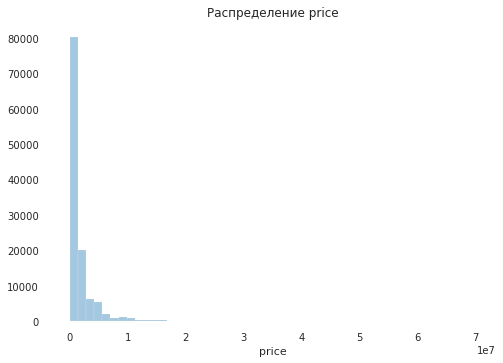

In [35]:
plt.figure()
plt.title(f"Распределение {'price'}")
sns.distplot(df.price, kde=False)

In [36]:
sign_study('price')

0.0           34686
450000.0        641
550000.0        591
350000.0        576
650000.0        558
              ...  
12363860.0        1
9744200.0         1
3091000.0         1
8140000.0         1
2313500.0         1
Name: price, Length: 12027, dtype: int64
0


**Тип кузова**

In [37]:
sign_study('body_type')

Внедорожник 5 дв.                      37585
Седан                                  23586
седан                                  13147
внедорожник 5 дв.                      12228
Хэтчбек 5 дв.                           6730
                                       ...  
Пикап Двойная кабина Raptor CrewCab        1
Пикап Полуторная кабина King Cab           1
Родстер Cooper S                           1
Универсал 5 дв. XC                         1
Компактвэн Joy                             1
Name: body_type, Length: 191, dtype: int64
0


In [38]:
# Приведем названия типов к единообразию, выбрав только первые элементы:

df['body_type'] = df['body_type'].astype(str).apply(lambda x: None if x.strip()=='' else x)
df['body_type'] = df.body_type.apply(lambda x: x.split(' ')[0].lower())

In [39]:
sign_study('body_type')

внедорожник      50522
седан            38651
хэтчбек          11617
лифтбек           6012
универсал         3947
минивэн           2865
купе              2161
компактвэн        1741
пикап              785
фургон             469
купе-хардтоп       339
кабриолет          225
родстер            208
микровэн            46
седан-хардтоп       26
тарга               12
лимузин              8
фастбек              1
Name: body_type, dtype: int64
0


In [40]:
# Заменим пропуски значениями, распределенными по вероятности:

mask = df["body_type"].isna()
# считаем статистику распределения значений
p = df["body_type"].value_counts() / len(df["body_type"].dropna())
# заполняем пропуски с вероятностью `p`
df.loc[mask, "body_type"] = \
    np.random.choice(p.index.to_list(), 
                     size=mask.sum(), 
                     p=p.to_list())

Посмотрим на распределение признака:

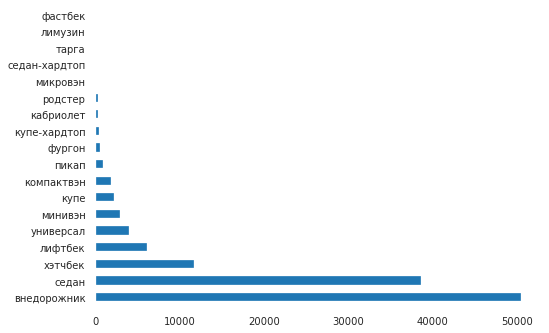

In [41]:
df.body_type.value_counts().plot.barh()

Добавим признак в список категориальных.

In [42]:
cat_cols.append('body_type')

**Название бренда**

In [43]:
sign_study('brand')

MERCEDES      15548
BMW           11742
VOLKSWAGEN    10113
NISSAN         9925
TOYOTA         7557
KIA            7108
AUDI           6993
SKODA          6186
MITSUBISHI     6179
HYUNDAI        5255
RENAULT        4236
FORD           3191
VOLVO          3163
LEXUS          2295
CHEVROLET      2288
HONDA          2053
OPEL           1976
MAZDA          1839
INFINITI       1560
LAND_ROVER     1466
PEUGEOT        1180
SUZUKI          826
CITROEN         819
PORSCHE         737
DAEWOO          710
JEEP            697
CHERY           611
MINI            584
SUBARU          578
SSANG_YONG      429
CADILLAC        394
GEELY           386
DODGE           290
JAGUAR          276
GREAT_WALL      263
CHRYSLER        182
Name: brand, dtype: int64
0


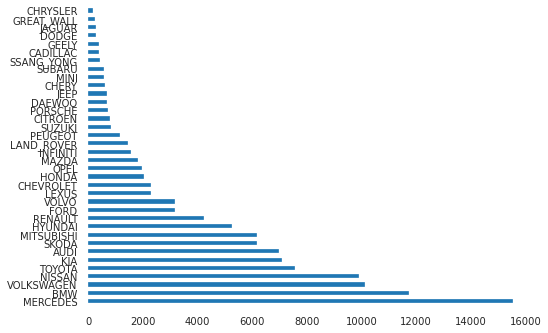

In [44]:
df.brand.value_counts().plot.barh()

In [45]:
cat_cols.append('brand')

**Цвет**

In [46]:
sign_study('color')

040001         23531
FAFBFB         16911
97948F         12182
чёрный         11010
0000CC          8652
CACECB          8066
белый           6133
EE1D19          4483
серебристый     4113
серый           3984
синий           3289
200204          3250
007F00          2252
C49648          1714
красный         1531
коричневый      1501
22A0F8          1248
зелёный          952
FFD600           640
бежевый          639
FF8649           615
DEA522           502
660099           475
голубой          457
4A2197           405
золотистый       266
пурпурный        254
фиолетовый       219
жёлтый           194
оранжевый        131
FFC0CB            23
розовый           13
Name: color, dtype: int64
0


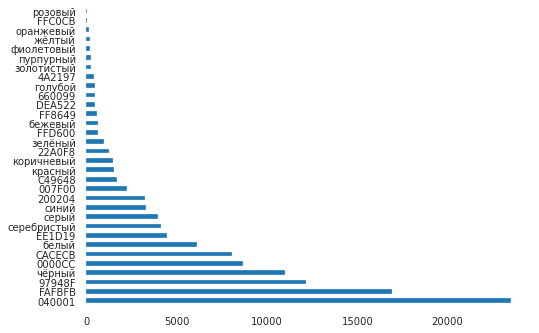

In [47]:
df.color.value_counts().plot.barh()

In [48]:
color_dict = {'черный': 'black',
              'чёрный': 'black',
              '040001':'black', 
              'зеленый':'green',
              'зелёный': 'green',
              '007F00': 'green',
              'CACECB':'grey',
              'серый':'grey',
              '97948F':'beige',
              'бежевый':'beige',
              '0000CC':'blue',
              'синий':'blue',
              'EE1D19':'red',
              'красный':'red',
              'FAFBFB':'white',
              'белый':'white',
              'серебристый':'silver',
              '200204':'purple',
              'пурпурный':'purple',
              'C49648':'brown',
              'коричневый':'brown',
              '22A0F8':'light blue',
              'голубой':'light blue',
              'FFD600':'yellow',
              'желтый':'yellow',
              'жёлтый':'yellow',
              'FF8649':'orange',
              'оранжевый':'orange',
              'DEA522':'golden',
              'золотистый':'golden',
              '660099':'violet',
              'фиолетовый':'violet',
              '4A2197':'violet',
              'FFC0CB':'rose',
              'розовый':'rose',
                           }
df['color'] = df['color'].map(color_dict)

In [49]:
sign_study('color')

black         34541
white         23044
beige         12821
grey          12050
blue          11941
red            6014
silver         4113
purple         3504
brown          3215
green          3204
light blue     1705
violet         1099
yellow          834
golden          768
orange          746
rose             36
Name: color, dtype: int64
0


In [50]:
# Добавим в словарь самые популярные цвета
color_list = ['black', 'white', 'beige', 'grey', 'blue']

#  Новый признак: популярный цвет - 1, остальные - 0
df['pop_color'] = df.color.apply(lambda x: 1 if x in color_list else 0)

In [51]:
cat_cols.append('color')
bin_cols.append('pop_color')

**Описание**

In [52]:
# description - описание, комментарий продавца
# сгенерируем из него новый числовой признак
df['description_len'] = df.description.apply(lambda x: len(str(x)))

In [53]:
'''Также из этого описания можно в некоторых случаях понять, имеем ли мы дело с салоном или с продавцом-частником. Сгенерируем признаки для этого'''

df['description'] = df['description'].map(lambda x: str(x).lower())

df['owner'] = df['description'].apply(lambda x: 1 if 'торг' in x or 'не нуждаюсь' in x or len(x)<200 else 0)
df['showroom'] = df['description'].apply(lambda x: 1 if 'traid-in' in x or 'дилер' in x or 'в кредит' in x or 'клиент' in x
                                              or 'без комис' in x or 'страховани' in x or 'трейд-ин' in x 
                                              or 'в наличии' in x or 'выгодное пр' in x or 'автокредит' in x else 0)
display(df['owner'].value_counts())
display(df['showroom'].value_counts())

0    73709
1    45926
Name: owner, dtype: int64

0    63743
1    55892
Name: showroom, dtype: int64

In [54]:
df['new'] = df.description.apply(lambda x: 1 if 'нов' in x else 0)
df['tires'] = df.description.apply(lambda x: 1 if ('шины' in x) or ('резина' in x) else 0)
df['heating'] = df.description.apply(lambda x: 1 if 'подогрев сидений' in x else 0)
df['central_lock'] = df.description.apply(lambda x: 1 if 'центральный замок' in x else 0)
df['computer'] = df.description.apply(lambda x: 1 if 'бортовой компьютер' in x else 0)
df['airbag'] = df.description.apply(lambda x: 1 if 'подушки безопасности' in x else 0)
df['power_steering'] = df.description.apply(lambda x: 1 if 'усилитель руля' in x else 0)
df['cruise_control'] = df.description.apply(lambda x: 1 if 'круиз-контроль' in x else 0)
df['parktronic'] = df.description.apply(lambda x: 1 if 'парктроник' in x else 0)
df['child_car_seat'] = df.description.apply(lambda x: 1 if 'крепления детских автокресел' in x else 0)

In [55]:
# Теперь признак "Описание" нам не нужен.

df = df.drop('description',axis=1)

In [56]:
df['description_len'].isna().sum()

0

In [57]:
num_cols.append('description_len')

In [58]:
bin_cols = bin_cols + ['owner', 'showroom', 'new', 'tires', 'heating', 'central_lock', 'computer', 'airbag', 'power_steering', 'cruise_control', 'parktronic', 'child_car_seat']

**Вид топлива**

In [59]:
sign_study('fuel_type')

бензин     97589
дизель     21291
гибрид       520
электро      221
газ           14
Name: fuel_type, dtype: int64
0


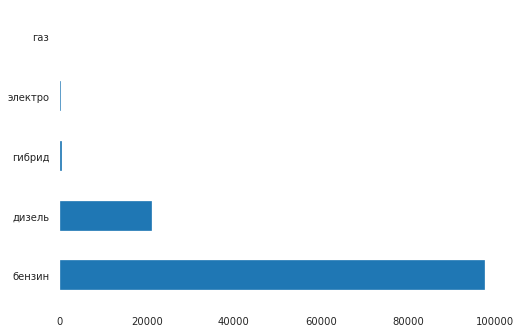

In [60]:
df.fuel_type.value_counts().plot.barh()

In [61]:
cat_cols.append('fuel_type')

**Объем двигателя**

In [62]:
df.engine_volume.unique()

array(['2.3', '2.6', '2.8', '2.0', '2.2', '1.8', 'S4', '2.4', '1.9',
       '2.5d', '2.1', '1.6', '3.3', '1.4', '35', '1.2', '1.5', 'ultra',
       '1.9d', '3.2', '40', '45', '2.0d', '3.0', '8V', '3.0d', '2.7d',
       '7S-tronic', 'tiptronic', '3.1', '55', '2.7', '4.2', 'clean',
       'Tiptronic', 'S-tronic', 'Long', '60', '6.0', '4.0', '50', '3.7',
       '4.1d', '2.0hyb', '8tiptronic', '3.6', '5.9d', 'V10', 'V8', '2.5',
       '2.9', '5.0', '5.2', '4.0d', '120i', '118i', '116i', 'M140i',
       '125i', '135i', '130i', 'M135i', '116d', '120d', '220i', '218i',
       'M235i', '220d', '216d', '214d', 'CS', '320i', '325i', '318d',
       '320d', '318i', '330d', '316i', '328i', 'M340i', '330i', '316',
       '335i', '323i', '325xi', '330xi', '320xd', '335xi', '325d', '335d',
       '420i', '420d', '430i', '428i', '435i', '418d', '440i', '528i',
       '520i', '520d', '535i', '530i', '525i', '530d', 'M550d', '523i',
       'M550i', '535d', '525d', '520Li', '550i', '530xi', '528Li', '518d

In [63]:
sign_study('engine_volume')

1.6        15027
2.0        13546
2.0 LTR     7391
1.6 LTR     4973
1.4         4949
           ...  
Europa         1
S4             1
Super          1
3.9            1
3.6hyb         1
Name: engine_volume, Length: 545, dtype: int64
0


In [64]:
# Значения надо почистить, для этого преобразуем их в строки:    
# df['engine_volume'] = df['engine_volume'].map(lambda x: str(x).lower())

In [65]:
# Извлечём из признака только числовые данные (объём двигателя в литрах) с помощью regex:
df['engine_volume'] = df['engine_volume'].str.extract('(\d.\d)',expand=False).str.strip()

In [66]:
sign_study('engine_volume')

2.0    22724
1.6    20206
1.8     6683
1.4     6626
3.0     6362
       ...  
418        1
126        1
7.0        1
214        1
0.6        1
Name: engine_volume, Length: 154, dtype: int64
10953


In [67]:
df['engine_volume'] = df['engine_volume'].astype(float)

In [68]:
mask = df["engine_volume"].isna()
# считаем статистику распределения значений
p = df["engine_volume"].value_counts() / len(df["engine_volume"].dropna())
# заполняем пропуски с вероятностью `p`
df.loc[mask, "engine_volume"] = \
    np.random.choice(p.index.to_list(), 
                     size=mask.sum(), 
                     p=p.to_list())

In [69]:
# Разобьем значения по категориям: 
# df["engine_volume"] = df["engine_volume"].astype('float').apply(lambda x: 4 if x >= 4 else 
#   3 if x >= 3 else(2 if x >= 2 else (1 if x >= 1 else 0)))
# df.engine_volume.value_counts()

In [70]:
# df['engine_volume'] = df['engine_volume'].fillna(5)

In [71]:
num_cols.append('engine_volume')

**Мощность двигателя**

In [72]:
sign_study('engine_power')

150       8790
249       5199
123       2536
110       2243
190       2186
          ... 
659          1
570          1
564          1
537          1
30 N12       1
Name: engine_power, Length: 710, dtype: int64
0


In [73]:
df['engine_power'] = df['engine_power'].astype(str).apply(lambda x: x.split()[0])
df['engine_power'] = df['engine_power'].astype(float)

In [74]:
num_cols.append('engine_power')

**Трансмиссия**

In [75]:
sign_study('transmission')

AUTOMATIC           49994
автоматическая      19596
MECHANICAL          19392
ROBOT                8063
VARIATOR             7500
механическая         7209
вариатор             3999
роботизированная     3882
Name: transmission, dtype: int64
0


In [76]:
transmis_dict = {'AUTOMATIC': 'автоматическая',
                 'автоматическая': 'автоматическая',
              'MECHANICAL': 'механическая',
              'механическая': 'механическая',
              'ROBOT': 'роботизированная', 
               'роботизированная': 'роботизированная',
              'VARIATOR': 'вариатор',
              'вариатор': 'вариатор'
                           }
df['transmission'] = df['transmission'].map(transmis_dict)

In [77]:
sign_study('transmission')

автоматическая      69590
механическая        26601
роботизированная    11945
вариатор            11499
Name: transmission, dtype: int64
0


In [78]:
df.index[df['transmission'].isna()].tolist()

[]

In [79]:
cat_cols.append('transmission')

**Пробег**

In [80]:
sign_study('mileage')

0         25979
200000     1165
150000      969
250000      920
300000      880
          ...  
171707        1
214720        1
198344        1
69321         1
86373         1
Name: mileage, Length: 29221, dtype: int64
0


In [81]:
df['mileage'] = df['mileage'].apply(lambda x: str(x).replace('\xa0км', ''))

In [82]:
df['mileage'] = df['mileage'].astype(float)

In [83]:
df['mileage'] = df['mileage'].fillna(df['mileage'].mean())

In [84]:
df['mileage'] = df['mileage'].apply(lambda x: round(x))

In [85]:
sign_study('mileage')

0         25979
200000     1165
150000      969
250000      920
300000      880
          ...  
171707        1
214720        1
198344        1
69321         1
86373         1
Name: mileage, Length: 29221, dtype: int64
0


In [86]:
df.mileage.describe()

count     119635.000000
mean      123459.514206
std       108337.259296
min            0.000000
25%        20000.000000
50%       115000.000000
75%       189000.000000
max      1000000.000000
Name: mileage, dtype: float64

In [87]:
num_cols.append('mileage')

**Привод**

In [88]:
sign_study('type_of_drive')

передний    56698
полный      53583
задний       9354
Name: type_of_drive, dtype: int64
0


In [89]:
cat_cols.append('type_of_drive')

**Дата выпуска модели и дата выпуска конкретной машины**

In [90]:
sign_study('model_date')


2017    8010
2020    7910
2018    7718
2010    6799
2019    6285
        ... 
1969       1
1904       1
1927       1
1957       1
1952       1
Name: model_date, Length: 75, dtype: int64
0


In [91]:
sign_study('production_date')

2021    25735
2012     7549
2013     6921
2008     6860
2011     6650
        ...  
1957        1
1956        1
1939        1
1966        1
1904        1
Name: production_date, Length: 76, dtype: int64
0


In [92]:
df['model_date'] = df['model_date'].fillna(df['model_date'].median())

In [93]:
df['model_date'] = df['model_date'].astype(int)

In [94]:
df['production_date'] = df['production_date'].astype(int)

In [95]:
#создадим новые признаки на основе существующих: количество лет производства и возраст модели
df['prod_age'] = 2021 - df.production_date
df['model_age'] = 2021 - df.model_date

In [96]:
#определим эти признаки в числовые данные

num_cols = num_cols + ['production_date', 'model_date', 'model_age', 'prod_age']

Создадим на их основе категориальные признаки - это на несколько сотых долей ухудшит показатели модели в обучении, но улучшит их при сабмите в соревновании.

**Название модели**

In [97]:
sign_study('model_name')

OCTAVIA      2590
E_KLASSE     2548
POLO         2305
X_TRAIL      2173
5ER          2097
             ... 
CABRIOLET       1
SIMPLEX         1
TITAN           1
RAIDER          1
MARK_2          1
Name: model_name, Length: 1098, dtype: int64
0


In [98]:
df['model_name'] = df['model_name'].fillna('неизвестна')

In [99]:
cat_cols.append('model_name')

**Количество владельцев**

In [100]:
sign_study('owners_qty')

1.0            17453
3 или более    15957
2.0            15395
3.0            14610
4.0            11512
1 владелец      9459
2 владельца     9270
Name: owners_qty, dtype: int64
25979


In [101]:
df['owners_qty'] = df['owners_qty'].str.extract('(\d)',expand=False).str.strip()

In [102]:
df['owners_qty'] = df['owners_qty'].fillna('1.0')

In [103]:
cat_cols.append('owners_qty')

**ПТС**

In [104]:
sign_study('licence')

ORIGINAL     76032
Оригинал     30098
DUPLICATE     8385
Дубликат      4587
Name: licence, dtype: int64
533


In [105]:
licence_dict = {'ORIGINAL': 'оригинал',
                 'Оригинал': 'оригинал',
              'DUPLICAT': 'дубликат',
              'Дубликат': 'дубликат'
                           }
df['licence'] = df['licence'].map(licence_dict)

In [106]:
df['licence'] = df['licence'].fillna('оригинал')

In [107]:
bin_cols.append('licence')

**Руль**

In [108]:
sign_study('steering_wheel')

LEFT      83567
Левый     33287
Правый     1399
RIGHT      1382
Name: steering_wheel, dtype: int64
0


In [109]:
wheel_dict = {'LEFT': 'левый',
                 'RIGHT': 'правый',
              'Левый': 'левый',
              'Правый': 'правый'
                           }
df['steering_wheel'] = df['steering_wheel'].map(wheel_dict)

In [110]:
bin_cols.append('steering_wheel')

**vehicleConfiguration**

In [111]:
sign_study('vehicle_configuration')

ALLROAD_5_DOORS AUTOMATIC 2.0    4947
ALLROAD_5_DOORS VARIATOR 2.0     4818
SEDAN MECHANICAL 1.6             4272
SEDAN AUTOMATIC 1.6              4019
SEDAN AUTOMATIC 2.0              3877
                                 ... 
PICKUP_TWO MECHANICAL 79            1
COUPE AUTOMATIC 335xi               1
ROADSTER MECHANICAL Carrera         1
COMPACTVAN MECHANICAL 1.5hyb        1
HATCHBACK_4_DOORS ROBOT 1.6         1
Name: vehicle_configuration, Length: 1962, dtype: int64
0


In [112]:
df['vehicle_configuration'] = df['vehicle_configuration'].astype(
               str).apply(lambda x: x if len(x) == 1 else x.split())

In [113]:
df['vehicle_configuration'] = df['vehicle_configuration'].apply(
    lambda x: x[0].lower() if len(x) == 1 else x[1].lower())

In [114]:
sign_study('vehicle_configuration')

automatic     69590
mechanical    26601
robot         11945
variator      11499
Name: vehicle_configuration, dtype: int64
0


In [115]:
cat_cols.append('vehicle_configuration')

**Количество дверей**

In [116]:
sign_study('doors')

5    73099
4    40988
2     3052
3     2495
0        1
Name: doors, dtype: int64
0


Бывают ли автомобили без дверей? Проверим, что это за удивительный выброс...

In [117]:
df[df['doors'] == 0]

,sell_id,body_type,brand,color,fuel_type,model_date,name,model_name,doors,production_date,vehicle_configuration,transmission,engine_volume,engine_power,mileage,type_of_drive,steering_wheel,owners_qty,licence,customs,ownership_time,state,price,train,pop_color,description_len,owner,showroom,new,tires,heating,central_lock,computer,airbag,power_steering,cruise_control,parktronic,child_car_seat,prod_age,model_age
101893,1.093802e+09,кабриолет,MERCEDES,white,бензин,1904,5.3 MT (32 л.с.),SIMPLEX,0,1904,mechanical,механическая,5.3,32.0,48000,задний,правый,1,оригинал,Растаможен,6 лет и 8 месяцев,Не требует ремонта,0.0,0,1,785,0,0,1,1,0,0,0,0,0,0,0,0,117,117


Мы посмотрели на модель мерседеса выпуска 1904 года и свидетельствуем, что дверей там действительно нет. Это не выброс, оставляем.



In [118]:
df['doors'] = df['doors'].astype(int)

In [119]:
cat_cols.append('doors')

**Время владения**

In [120]:
sign_study('ownership_time')

{'year': 2021, 'month': 1}     406
{'year': 2020, 'month': 10}    386
{'year': 2020, 'month': 12}    379
{'year': 2020, 'month': 8}     378
{'year': 2020, 'month': 11}    367
                              ... 
42 года и 10 месяцев             1
19 лет и 9 месяцев               1
31 год и 5 месяцев               1
{'year': 1996, 'month': 11}      1
{'year': 1994, 'month': 11}      1
Name: ownership_time, Length: 571, dtype: int64
88561


In [121]:
'''
import re

# Вытащим числа из этого признака "ownership_time":
df['ownership_time'] = df['ownership_time'].apply(lambda x: x if pd.isna(x) else re.findall(r'\d+', x))

# Переведем время владения в месяцы:
def get_months(x):
    if type(x) != list:
        return x
    elif len(x) == 2:
        return int(x[0])*12 + int(x[1])
    else:
        return int(x[0])
      
    
# Применим функцию к колонке:
df['ownership_time'] = df['ownership_time'].apply(get_months)

# Если данных нет, то заполним их нулями (потому что всем остальным заполнять хуже):
df['ownership_time'] = df['ownership_time'].fillna(value=0)
'''

'\nimport re\n\n# Вытащим числа из этого признака "ownership_time":\ndf[\'ownership_time\'] = df[\'ownership_time\'].apply(lambda x: x if pd.isna(x) else re.findall(r\'\\d+\', x))\n\n# Переведем время владения в месяцы:\ndef get_months(x):\n    if type(x) != list:\n        return x\n    elif len(x) == 2:\n        return int(x[0])*12 + int(x[1])\n    else:\n        return int(x[0])\n      \n    \n# Применим функцию к колонке:\ndf[\'ownership_time\'] = df[\'ownership_time\'].apply(get_months)\n\n# Если данных нет, то заполним их нулями (потому что всем остальным заполнять хуже):\ndf[\'ownership_time\'] = df[\'ownership_time\'].fillna(value=0)\n'

In [122]:
# num_cols.append('ownership_time')
df = df.drop(['ownership_time'], axis=1)

# Новые признаки

In [123]:
# Посчитаем новые признаки - среднюю цену для перечисленных признаков:
for col in ['model_name', 'brand', 'body_type', 'engine_volume', 'engine_power']:
    col_means = df.groupby([col])['price'].mean().to_dict()
    df[col + '_' + 'price'] = df[col].apply(lambda x: col_means[x])

In [124]:
num_cols = num_cols + ['brand_price', 'model_name_price', 'body_type_price', 'engine_volume_price', 'engine_power_price']

In [125]:
df['luxury'] = df['brand'].apply(lambda x: 1 if x in ['BMW','MERCEDES','LEXUS','INFINITI', 'VOLVO'] else 0)
bin_cols.append('luxury')

In [126]:
df['km_year'] = df['mileage']/(df['prod_age']+1)


num_cols.append('km_year')

In [127]:
# И дополним все числовые признаки категориальными

for col in num_cols:
    df[col + '_' + 'cat'] = 0
    perc25 = df[col].quantile(0.25)
    perc50 = df[col].quantile(0.5)
    perc75 = df[col].quantile(0.75)
    df[col + '_' + 'cat'] = df[col].apply(lambda x: sign_to_cat(x))
    df[col + '_' + 'cat'] = df[col + '_' + 'cat'].astype('category').cat.codes

# Лишние признаки

**Таможня**

In [128]:
df.customs.value_counts()

True          84949
Растаможен    34686
Name: customs, dtype: int64

In [129]:
# Всего одно значение для всех? Конечно, удалим!
df = df.drop(['customs'], axis=1)

**Состояние**

In [130]:
df.state.value_counts()

Не требует ремонта    34686
Name: state, dtype: int64

In [131]:
# То же самое
df = df.drop(['state'], axis=1)

**Удаление оставшихся лишних колонок**

In [132]:
df = df.drop('name', 1)

In [133]:
df = df.drop(['sell_id'], axis=1)

# Анализ групп признаков

In [134]:
df.isna().sum()

body_type                  0
brand                      0
color                      0
fuel_type                  0
model_date                 0
model_name                 0
doors                      0
production_date            0
vehicle_configuration      0
transmission               0
engine_volume              0
engine_power               0
mileage                    0
type_of_drive              0
steering_wheel             0
owners_qty                 0
licence                    0
price                      0
train                      0
pop_color                  0
description_len            0
owner                      0
showroom                   0
new                        0
tires                      0
heating                    0
central_lock               0
computer                   0
airbag                     0
power_steering             0
cruise_control             0
parktronic                 0
child_car_seat             0
prod_age                   0
model_age     

# Бинарные признаки

In [135]:
for i in bin_cols:
    print('В столбце {} {} пропущенных значений'.format(i, df[i].isna().sum()))

В столбце pop_color 0 пропущенных значений
В столбце owner 0 пропущенных значений
В столбце showroom 0 пропущенных значений
В столбце new 0 пропущенных значений
В столбце tires 0 пропущенных значений
В столбце heating 0 пропущенных значений
В столбце central_lock 0 пропущенных значений
В столбце computer 0 пропущенных значений
В столбце airbag 0 пропущенных значений
В столбце power_steering 0 пропущенных значений
В столбце cruise_control 0 пропущенных значений
В столбце parktronic 0 пропущенных значений
В столбце child_car_seat 0 пропущенных значений
В столбце licence 0 пропущенных значений
В столбце steering_wheel 0 пропущенных значений
В столбце luxury 0 пропущенных значений


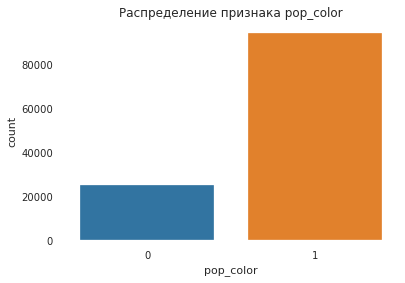

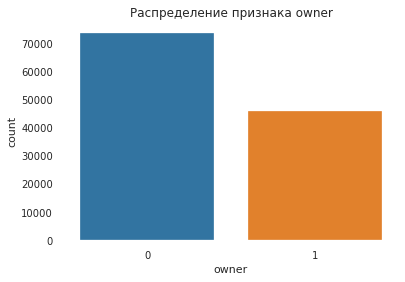

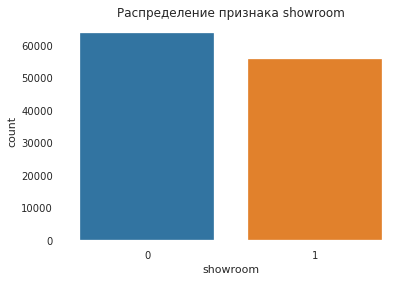

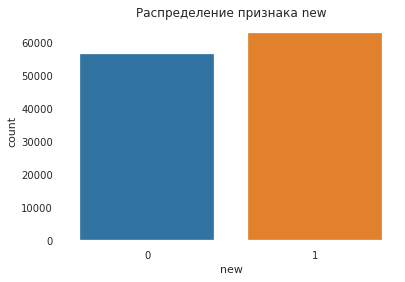

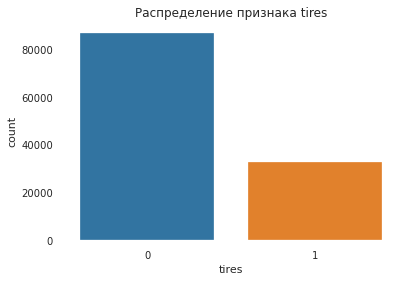

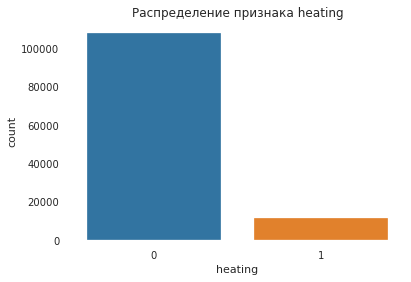

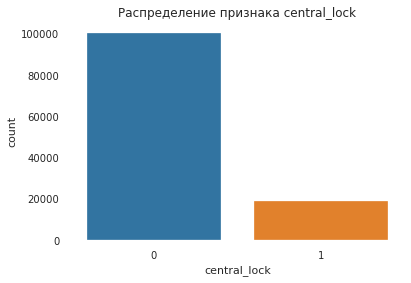

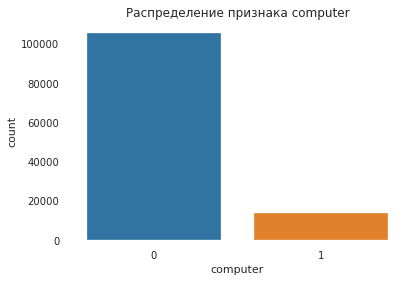

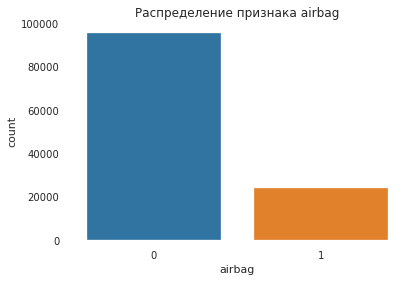

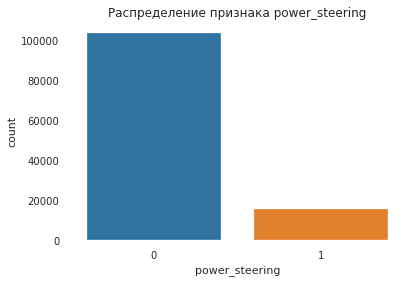

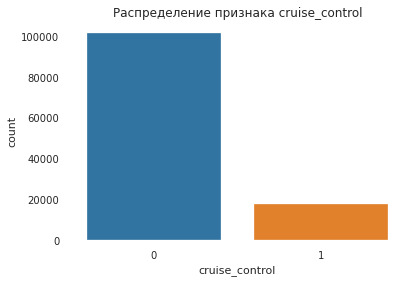

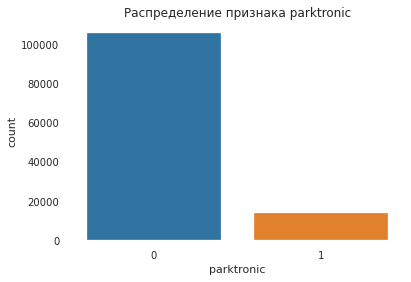

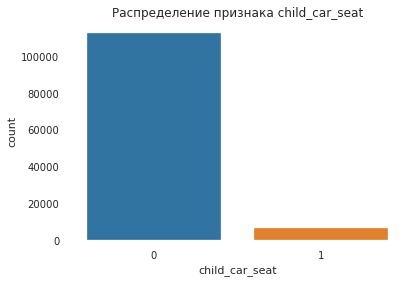

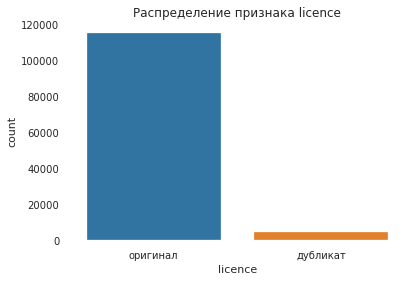

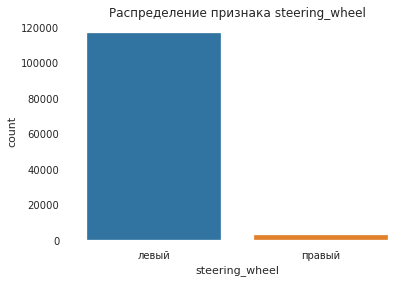

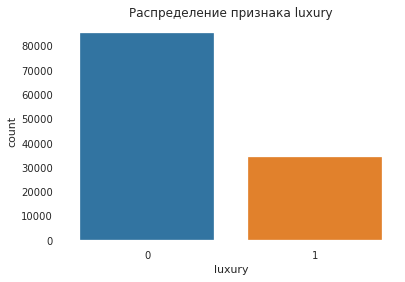

In [136]:
for col in bin_cols:
    plt.figure(figsize=(6, 4))
    sns.countplot(df[col])
    plt.title(f"Распределение признака {col}")

Казалось бы, некоторые признаки с большой разницей между 0 и 1 можно удалить. Но сначала давайте посмотрим на корреляции и на значимость.

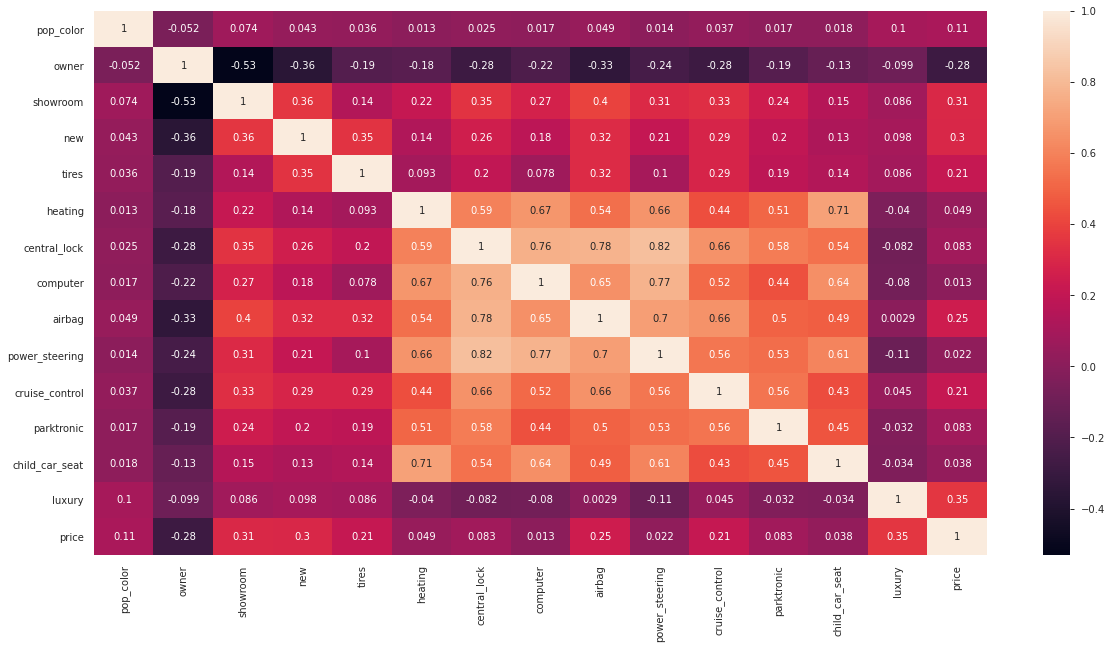

In [137]:
plt.figure(figsize=(20,10))
sns.heatmap(df[bin_cols+['price']].corr(), annot=True)

In [138]:
# Заменим значения бинарных признаков на 0 и 1:
label_encoder = LabelEncoder()
for i in bin_cols:
    df[i] = label_encoder.fit_transform(df[i])

Text(0.5, 1.0, 'Значимость бинарных признаков')

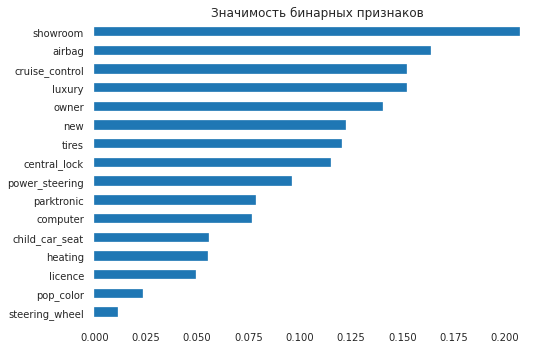

In [139]:
# значимость бинарных признаков

from sklearn.feature_selection import mutual_info_regression

imp_bin = Series(mutual_info_regression(df[bin_cols], df['price'],
                                     discrete_features =True), index = bin_cols)
imp_bin.sort_values(inplace = True)
imp_bin.plot(kind = 'barh')
plt.title('Значимость бинарных признаков')

После исследования мы видим, что все признаки мало коррелируют и все более или менее значимы для модели. Оставим все (удаление портит результат, я проверила).

# Числовые признаки

In [140]:
for i in num_cols:
    print('В столбце {} {} пропущенных значений'.format(i, df[i].isna().sum()))

В столбце description_len 0 пропущенных значений
В столбце engine_volume 0 пропущенных значений
В столбце engine_power 0 пропущенных значений
В столбце mileage 0 пропущенных значений
В столбце production_date 0 пропущенных значений
В столбце model_date 0 пропущенных значений
В столбце model_age 0 пропущенных значений
В столбце prod_age 0 пропущенных значений
В столбце brand_price 0 пропущенных значений
В столбце model_name_price 0 пропущенных значений
В столбце body_type_price 0 пропущенных значений
В столбце engine_volume_price 0 пропущенных значений
В столбце engine_power_price 0 пропущенных значений
В столбце km_year 0 пропущенных значений


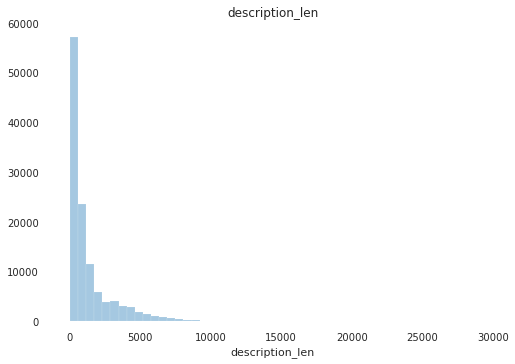

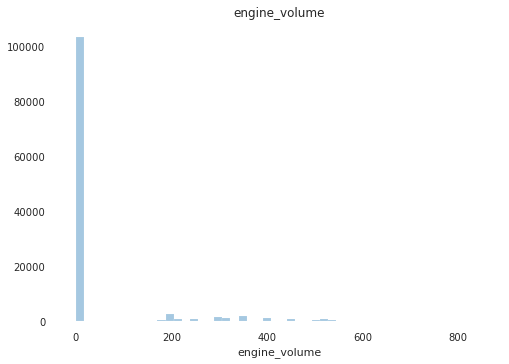

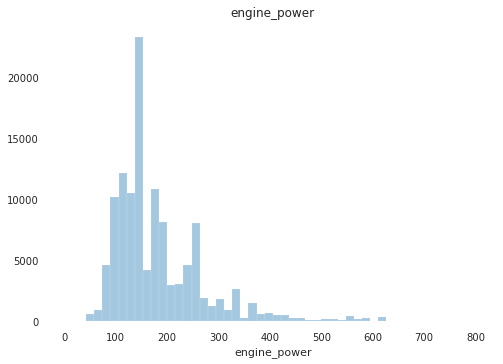

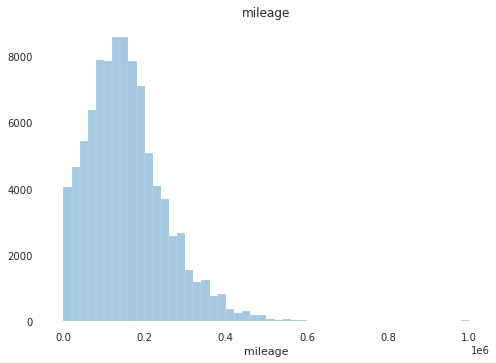

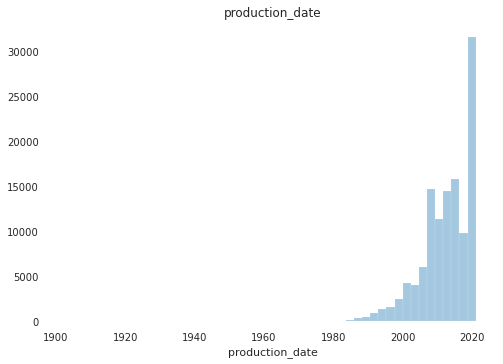

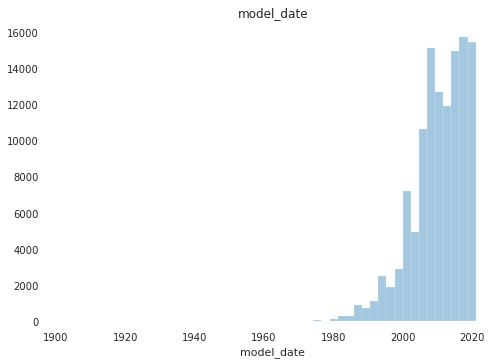

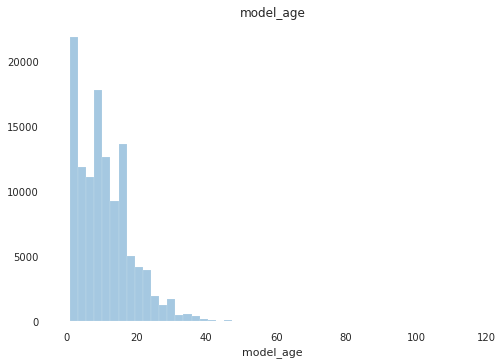

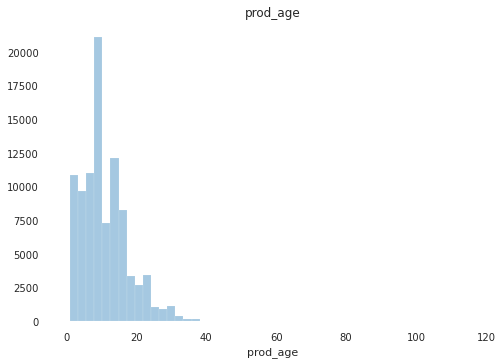

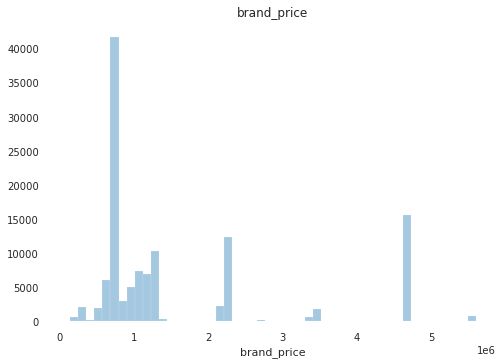

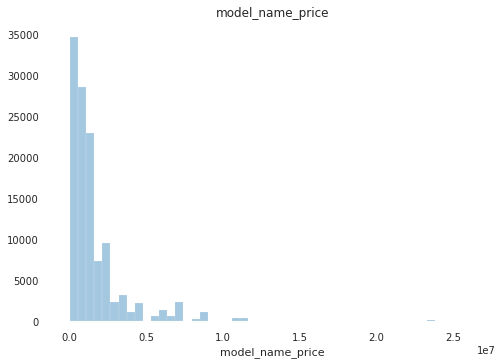

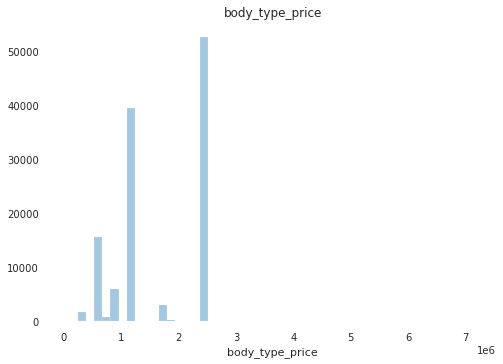

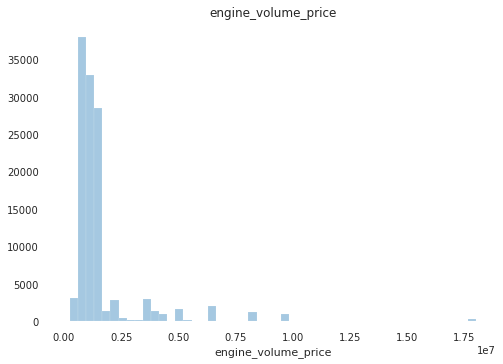

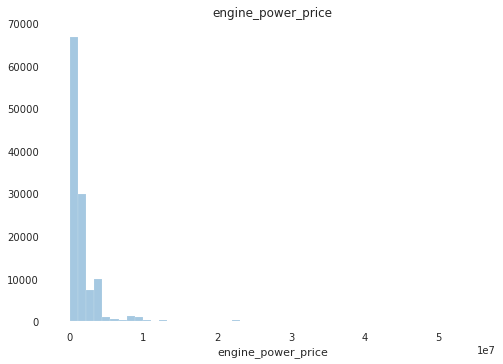

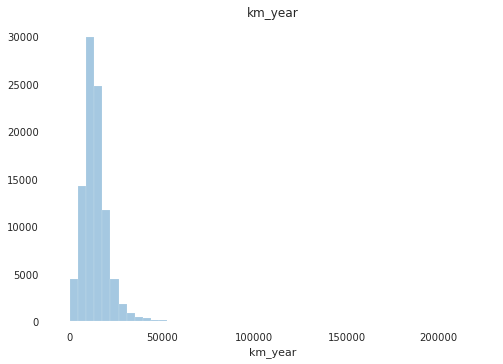

In [141]:
# Поглядим на распределение числовых признаков:
for i in num_cols:
    plt.figure()
    sns.distplot(df[i][df[i] > 0].dropna(), kde=False, rug=False)
    plt.title(i)
    plt.show()

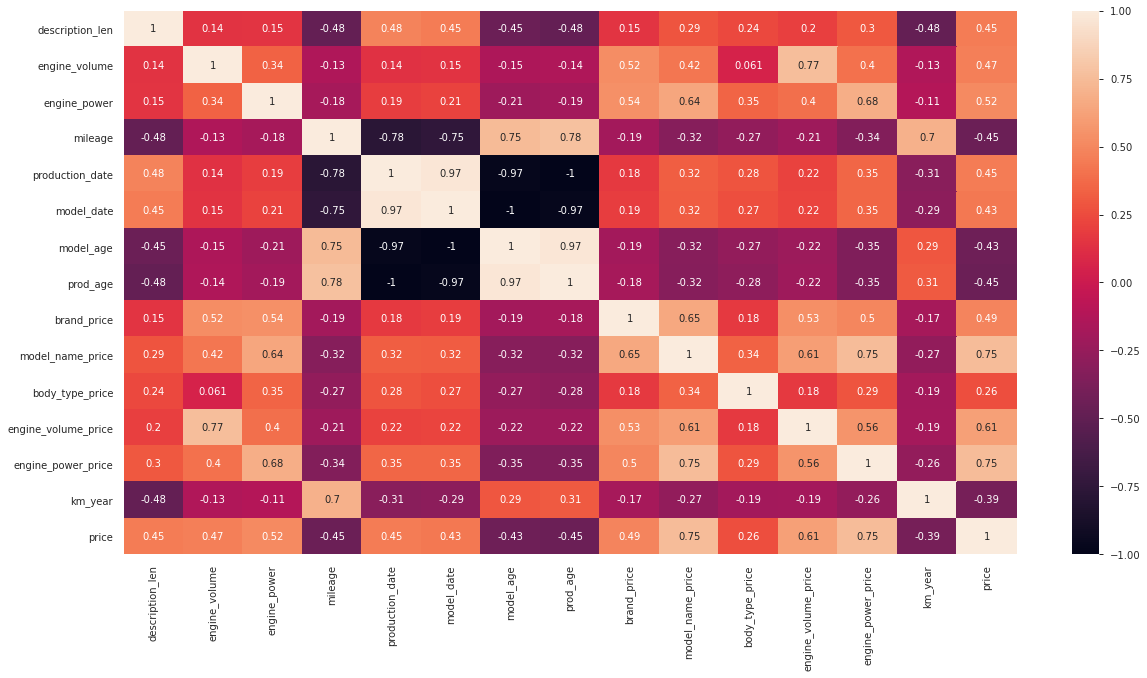

In [142]:
plt.figure(figsize=(20,10))
sns.heatmap(df[num_cols+['price']].corr(), annot=True)

Несмотря на то, что некоторые признаки сильно коррелируют друг с другом (дата выпуска модели и дата производства машины, возраст модели и машины), их удаление влечет за собой сильное ухудшение модели.

Text(0.5, 1.0, 'Значимость числовых признаков')

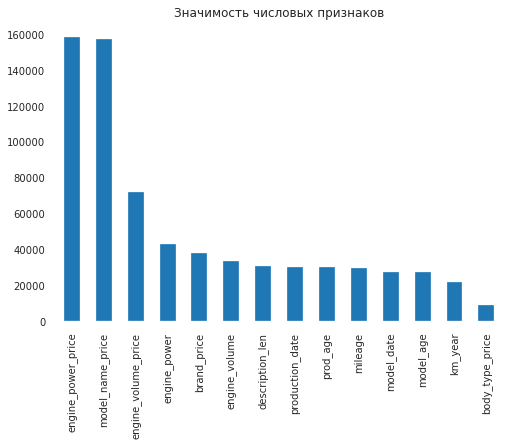

In [143]:
# используем дисперсионный анализ для определения значимости числовых признаков

from sklearn.feature_selection import f_regression

imp_num = pd.Series(f_regression(df[num_cols], df["price"])[0], index=num_cols)
imp_num.sort_values(inplace=True, ascending=False)
imp_num.plot(kind="bar")
plt.title('Значимость числовых признаков')

Кажется, здесь нам тоже нечего удалять.

# Категориальные признаки

In [144]:
for i in cat_cols:
    print('В столбце {} {} пропущенных значений'.format(i, df[i].isna().sum()))

В столбце body_type 0 пропущенных значений
В столбце brand 0 пропущенных значений
В столбце color 0 пропущенных значений
В столбце fuel_type 0 пропущенных значений
В столбце transmission 0 пропущенных значений
В столбце type_of_drive 0 пропущенных значений
В столбце model_name 0 пропущенных значений
В столбце owners_qty 0 пропущенных значений
В столбце vehicle_configuration 0 пропущенных значений
В столбце doors 0 пропущенных значений


Поскольку значений для признаков у нас очень много, удобнее проводить анализ после того, как мы переведем их в числовую форму.

In [145]:
# Переведем для всех категориальных признаков значения в числа:
for column in cat_cols:
    df[column] = df[column].astype('category').cat.codes

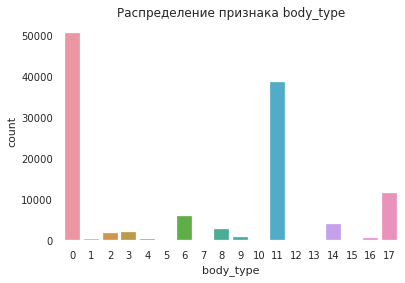

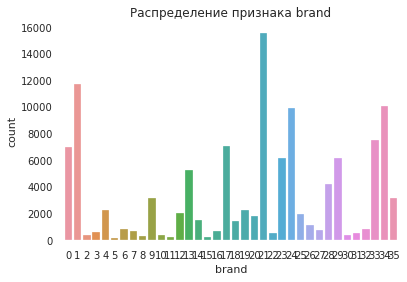

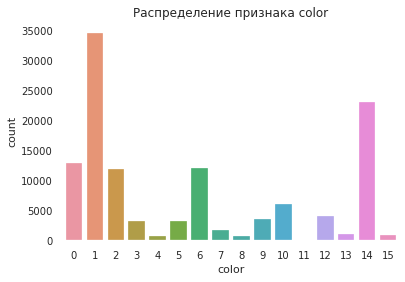

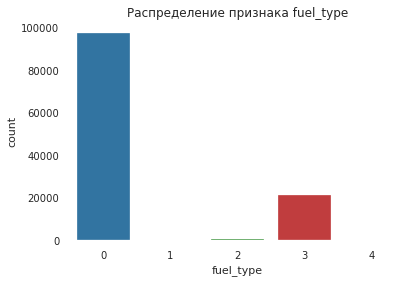

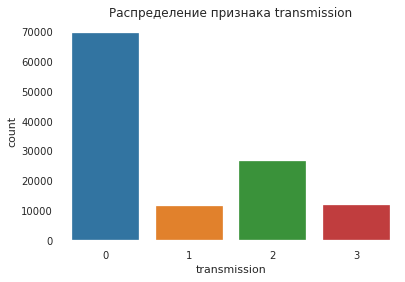

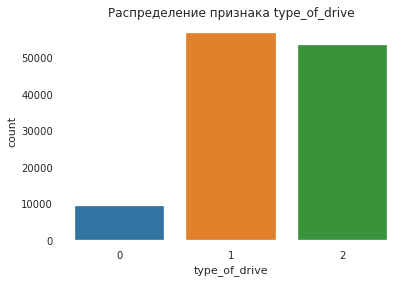

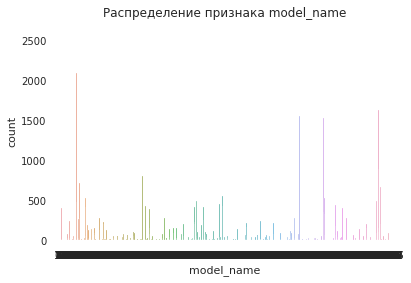

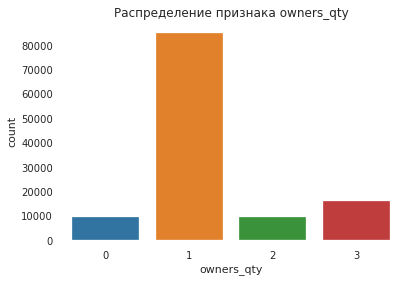

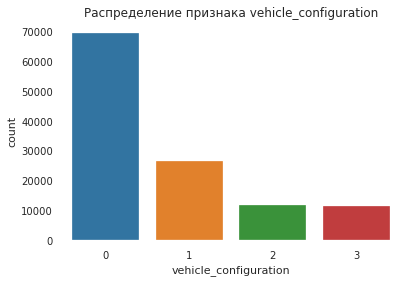

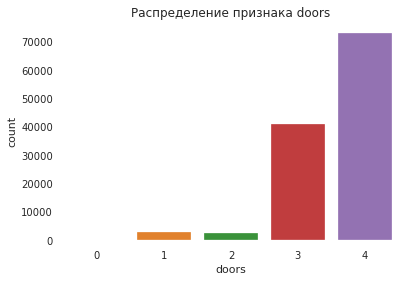

In [146]:
# Построим графики распределения значений по их количеству:
for col in cat_cols:
    plt.figure(figsize=(6, 4))
    sns.countplot(df[col])
    plt.title(f"Распределение признака {col}")

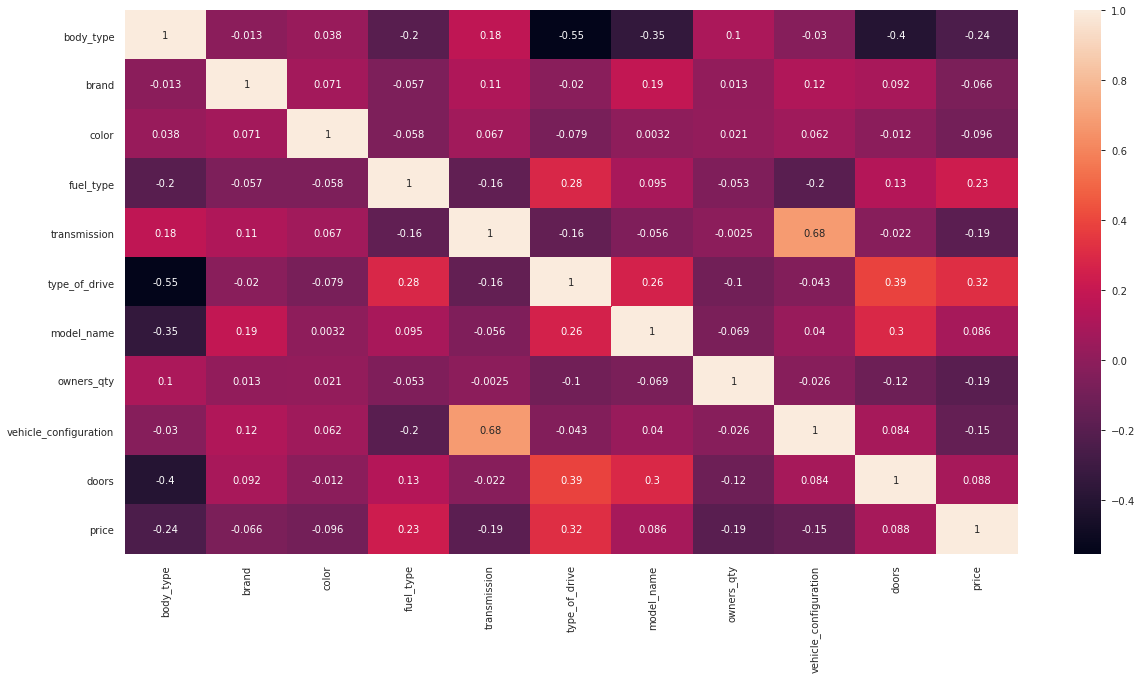

In [147]:
plt.figure(figsize=(20,10))
sns.heatmap(df[cat_cols+['price']].corr(), annot=True)

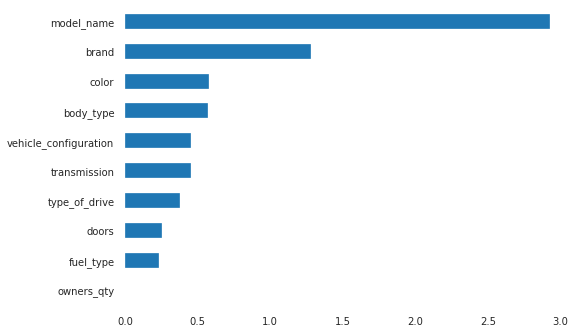

In [148]:
# Проверим значимость категориальных переменных:

from sklearn.feature_selection import mutual_info_classif

temp_df = df[df['train'] == 1]
imp_cat = Series(mutual_info_classif(temp_df[cat_cols],
                 temp_df['price'], discrete_features=True),
                 index=cat_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

## Оставшиеся преобразования

Можно логарифмировать числовые признаки для нормализации распределения, но от этого результат меняется не слишком сильно.

In [149]:
for i in ['engine_power', 'mileage', 'model_age', 'prod_age', 'brand_price', 
          'model_name_price', 'body_type_price', 'engine_volume_price', 'engine_power_price']:
    df[i] = df[i].apply(lambda x: np.log(x+1))

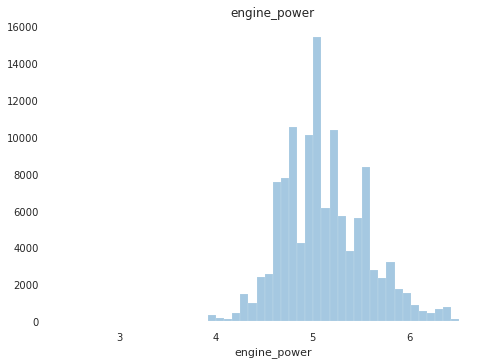

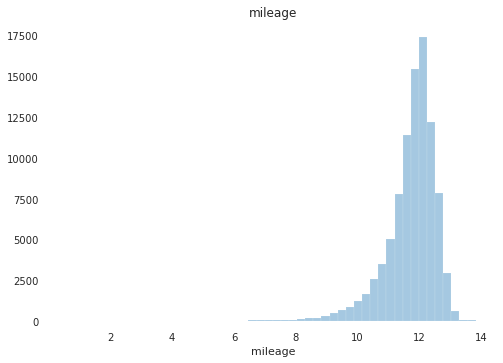

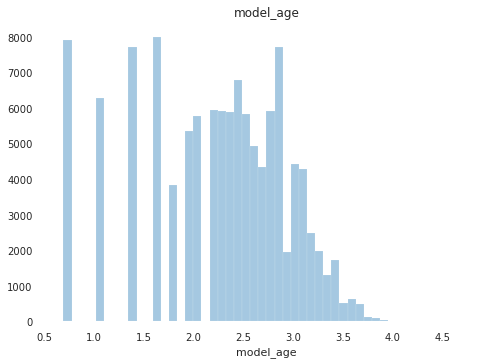

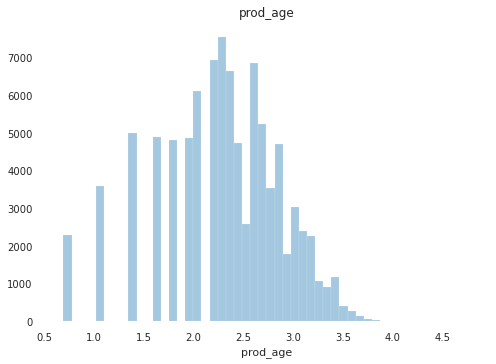

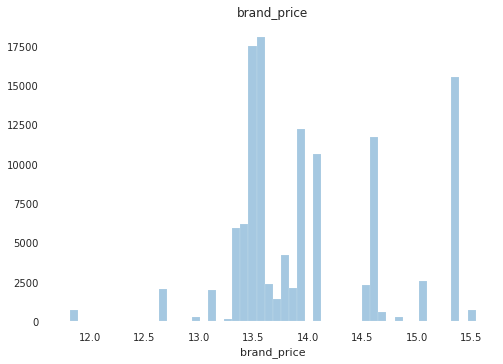

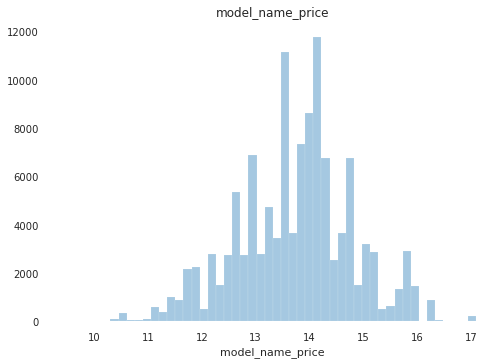

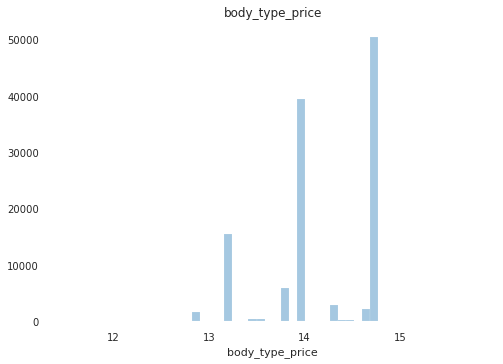

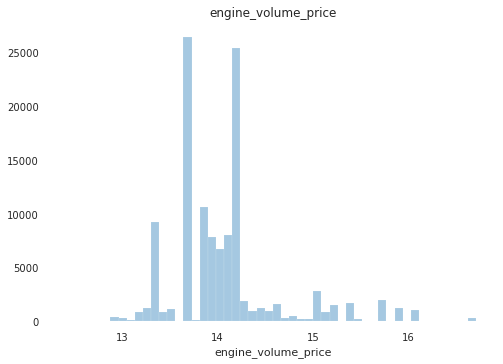

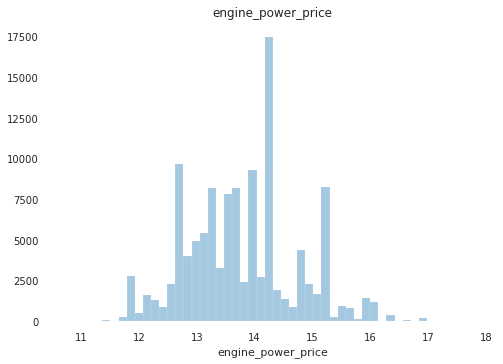

In [150]:
# Поглядим на распределение числовых признаков:
for i in ['engine_power', 'mileage', 'model_age', 'prod_age', 'brand_price', 
          'model_name_price', 'body_type_price', 'engine_volume_price', 'engine_power_price']:
    plt.figure()
    sns.distplot(df[i][df[i] > 0].dropna(), kde=False, rug=False)
    plt.title(i)
    plt.show()

In [151]:
# Для контроля выведем наш датасет еще раз:
df.head()

,body_type,brand,color,fuel_type,model_date,model_name,doors,production_date,vehicle_configuration,transmission,engine_volume,engine_power,mileage,type_of_drive,steering_wheel,owners_qty,licence,price,train,pop_color,description_len,owner,showroom,new,tires,heating,central_lock,computer,airbag,power_steering,cruise_control,parktronic,child_car_seat,prod_age,model_age,model_name_price,brand_price,body_type_price,engine_volume_price,engine_power_price,luxury,km_year,description_len_cat,engine_volume_cat,engine_power_cat,mileage_cat,production_date_cat,model_date_cat,model_age_cat,prod_age_cat,brand_price_cat,model_name_price_cat,body_type_price_cat,engine_volume_price_cat,engine_power_price_cat,km_year_cat
0,11,0,1,0,1990,1,3,1991,1,2,2.3,4.89784,12.694656,1,0,1,1,150000.0,1,1,1432,1,0,1,1,0,0,0,0,0,0,0,0,3.433987,3.465736,11.058876,13.95091,13.956721,13.552600,11.744401,0,10516.129032,2,2,1,3,0,0,3,3,2,0,0,0,0,1
1,11,0,1,0,1990,1,3,1994,1,2,2.3,4.89784,12.296832,1,0,1,1,120000.0,1,1,49,1,0,0,0,0,0,0,0,0,0,0,0,3.332205,3.465736,11.058876,13.95091,13.956721,13.552600,11.744401,0,7821.428571,0,2,1,3,0,0,3,3,2,0,0,0,0,1
2,11,0,5,0,1990,1,3,1993,0,0,2.6,5.01728,12.914111,1,0,1,1,165000.0,1,0,768,1,0,1,0,0,0,0,0,0,0,0,0,3.367296,3.465736,11.058876,13.95091,13.956721,13.252975,14.244202,0,14000.000000,2,2,1,3,0,0,3,3,2,0,0,0,2,2
3,11,0,10,0,1990,1,3,1991,0,0,2.3,4.89784,12.896719,1,0,1,1,75000.0,1,0,36,1,0,0,0,0,0,0,0,0,0,0,0,3.433987,3.465736,11.058876,13.95091,13.956721,13.552600,11.744401,0,12870.967742,0,2,1,3,0,0,3,3,2,0,0,0,0,2
4,11,0,0,0,1990,1,3,1991,1,2,2.3,4.89784,12.861887,1,0,1,1,153000.0,1,1,715,0,1,1,0,0,0,0,0,0,0,0,0,3.433987,3.465736,11.058876,13.95091,13.956721,13.552600,11.744401,0,12430.354839,2,2,1,3,0,0,3,3,2,0,0,0,0,2


Теперь сравним то, с чего мы начинали, с тем, что получили:

In [152]:
display(cars.info())
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119635 entries, 0 to 119634
Data columns (total 37 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   bodyType              119635 non-null  object 
 1   brand                 119635 non-null  object 
 2   color                 119635 non-null  object 
 3   fuelType              119635 non-null  object 
 4   modelDate             119635 non-null  int64  
 5   name                  119635 non-null  object 
 6   numberOfDoors         119635 non-null  int64  
 7   productionDate        119635 non-null  int64  
 8   vehicleConfiguration  119635 non-null  object 
 9   vehicleTransmission   119635 non-null  object 
 10  engineDisplacement    119635 non-null  object 
 11  enginePower           119635 non-null  object 
 12  description           117435 non-null  object 
 13  mileage               119635 non-null  int64  
 14  Комплектация          84949 non-null   object 
 15  

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119635 entries, 0 to 119634
Data columns (total 56 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   body_type                119635 non-null  int8   
 1   brand                    119635 non-null  int8   
 2   color                    119635 non-null  int8   
 3   fuel_type                119635 non-null  int8   
 4   model_date               119635 non-null  int64  
 5   model_name               119635 non-null  int16  
 6   doors                    119635 non-null  int8   
 7   production_date          119635 non-null  int64  
 8   vehicle_configuration    119635 non-null  int8   
 9   transmission             119635 non-null  int8   
 10  engine_volume            119635 non-null  float64
 11  engine_power             119635 non-null  float64
 12  mileage                  119635 non-null  float64
 13  type_of_drive            119635 non-null  int8   
 14  stee

None

# Необходимые приготовления к обучению

In [153]:
# Зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [154]:
# Фиксируем RANDOM_SEED, чтобы наши эксперименты были воспроизводимы:
RANDOM_SEED = 42
VAL_SIZE = 0.2

# Разделяем тестовую и тренировочную части

In [155]:
train = df.query('train == 1').drop(['train'], axis=1)
test = df.query('train == 0').drop(['train'], axis=1)

In [156]:
test = test.drop(['price'], axis=1)

In [157]:
X = train.drop(['price'], axis=1)
y = train['price']
X_sub = test

In [158]:
print('Размерность тестового датасета: ', test.shape)
display(test.head(5))

Размерность тестового датасета:  (34686, 54)


,body_type,brand,color,fuel_type,model_date,model_name,doors,production_date,vehicle_configuration,transmission,engine_volume,engine_power,mileage,type_of_drive,steering_wheel,owners_qty,licence,pop_color,description_len,owner,showroom,new,tires,heating,central_lock,computer,airbag,power_steering,cruise_control,parktronic,child_car_seat,prod_age,model_age,model_name_price,brand_price,body_type_price,engine_volume_price,engine_power_price,luxury,km_year,description_len_cat,engine_volume_cat,engine_power_cat,mileage_cat,production_date_cat,model_date_cat,model_age_cat,prod_age_cat,brand_price_cat,model_name_price_cat,body_type_price_cat,engine_volume_price_cat,engine_power_price_cat,km_year_cat
84949,6,29,2,0,2013,674,4,2014,2,3,1.2,4.663439,11.211834,1,0,3,1,1,1001,0,1,0,0,0,0,0,0,0,0,0,0,2.079442,2.197225,12.890747,13.447438,13.755846,13.356592,12.642482,0,9250.0,2,0,0,1,2,2,1,1,0,0,0,0,0,1
84950,6,29,1,0,2017,674,4,2017,1,2,1.6,4.709530,11.011456,1,0,0,1,1,2609,0,1,1,0,0,1,1,1,1,1,0,0,1.609438,1.609438,12.890747,13.447438,13.755846,13.710349,13.504343,0,12112.6,3,0,0,1,2,2,0,1,0,0,0,0,1,2
84951,6,29,6,0,2013,912,4,2014,2,3,1.8,5.030438,11.385103,1,0,0,1,1,1001,0,1,0,0,0,0,0,0,0,0,0,0,2.079442,2.197225,13.176979,13.447438,13.755846,13.338392,12.647915,0,11000.0,2,1,2,1,2,2,1,1,0,1,0,0,0,1
84952,6,29,3,0,2013,674,4,2014,0,0,1.6,4.709530,11.461643,1,0,0,1,0,1676,1,1,1,0,0,0,0,0,0,0,0,0,2.079442,2.197225,12.890747,13.447438,13.755846,13.710349,13.504343,0,11875.0,3,0,0,1,2,2,1,1,0,0,0,0,1,2
84953,6,29,14,0,2008,674,4,2012,0,0,1.8,5.030438,10.977414,1,0,0,1,1,2365,0,1,1,0,0,1,1,1,1,1,0,0,2.302585,2.639057,12.890747,13.447438,13.755846,13.338392,12.647915,0,5853.6,3,1,2,1,1,1,2,2,0,0,0,0,0,1


In [159]:
print('Размерность тренировочного датасета: ', train.shape)
display(train.head(5))

Размерность тренировочного датасета:  (84949, 55)


,body_type,brand,color,fuel_type,model_date,model_name,doors,production_date,vehicle_configuration,transmission,engine_volume,engine_power,mileage,type_of_drive,steering_wheel,owners_qty,licence,price,pop_color,description_len,owner,showroom,new,tires,heating,central_lock,computer,airbag,power_steering,cruise_control,parktronic,child_car_seat,prod_age,model_age,model_name_price,brand_price,body_type_price,engine_volume_price,engine_power_price,luxury,km_year,description_len_cat,engine_volume_cat,engine_power_cat,mileage_cat,production_date_cat,model_date_cat,model_age_cat,prod_age_cat,brand_price_cat,model_name_price_cat,body_type_price_cat,engine_volume_price_cat,engine_power_price_cat,km_year_cat
0,11,0,1,0,1990,1,3,1991,1,2,2.3,4.89784,12.694656,1,0,1,1,150000.0,1,1432,1,0,1,1,0,0,0,0,0,0,0,0,3.433987,3.465736,11.058876,13.95091,13.956721,13.552600,11.744401,0,10516.129032,2,2,1,3,0,0,3,3,2,0,0,0,0,1
1,11,0,1,0,1990,1,3,1994,1,2,2.3,4.89784,12.296832,1,0,1,1,120000.0,1,49,1,0,0,0,0,0,0,0,0,0,0,0,3.332205,3.465736,11.058876,13.95091,13.956721,13.552600,11.744401,0,7821.428571,0,2,1,3,0,0,3,3,2,0,0,0,0,1
2,11,0,5,0,1990,1,3,1993,0,0,2.6,5.01728,12.914111,1,0,1,1,165000.0,0,768,1,0,1,0,0,0,0,0,0,0,0,0,3.367296,3.465736,11.058876,13.95091,13.956721,13.252975,14.244202,0,14000.000000,2,2,1,3,0,0,3,3,2,0,0,0,2,2
3,11,0,10,0,1990,1,3,1991,0,0,2.3,4.89784,12.896719,1,0,1,1,75000.0,0,36,1,0,0,0,0,0,0,0,0,0,0,0,3.433987,3.465736,11.058876,13.95091,13.956721,13.552600,11.744401,0,12870.967742,0,2,1,3,0,0,3,3,2,0,0,0,0,2
4,11,0,0,0,1990,1,3,1991,1,2,2.3,4.89784,12.861887,1,0,1,1,153000.0,1,715,0,1,1,0,0,0,0,0,0,0,0,0,3.433987,3.465736,11.058876,13.95091,13.956721,13.552600,11.744401,0,12430.354839,2,2,1,3,0,0,3,3,2,0,0,0,0,2


In [160]:
print(train.columns, len(train.columns))
print(test.columns, len(test.columns))

Index(['body_type', 'brand', 'color', 'fuel_type', 'model_date', 'model_name',
       'doors', 'production_date', 'vehicle_configuration', 'transmission',
       'engine_volume', 'engine_power', 'mileage', 'type_of_drive',
       'steering_wheel', 'owners_qty', 'licence', 'price', 'pop_color',
       'description_len', 'owner', 'showroom', 'new', 'tires', 'heating',
       'central_lock', 'computer', 'airbag', 'power_steering',
       'cruise_control', 'parktronic', 'child_car_seat', 'prod_age',
       'model_age', 'model_name_price', 'brand_price', 'body_type_price',
       'engine_volume_price', 'engine_power_price', 'luxury', 'km_year',
       'description_len_cat', 'engine_volume_cat', 'engine_power_cat',
       'mileage_cat', 'production_date_cat', 'model_date_cat', 'model_age_cat',
       'prod_age_cat', 'brand_price_cat', 'model_name_price_cat',
       'body_type_price_cat', 'engine_volume_price_cat',
       'engine_power_price_cat', 'km_year_cat'],
      dtype='object') 55
Inde

## Train Split

In [161]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=RANDOM_SEED)

# Введем "наивную" модель 
Эта модель опять будет предсказывать среднюю цену по модели двигателя (engine_volume в нашем датасете). 
В базовом решении значение точности модели по метрике MAPE было равно 117.95% Из-за обработки данных (теперь у нас это категориальный признак) результат изменится - посмотрим, как именно.

In [162]:
tmp_train = X_train.copy()

In [163]:
tmp_train['price'] = y_train

In [164]:
# Находим median по экземплярам engine_volume в трейне и размечаем тест
predict = X_test['engine_volume'].map(tmp_train.groupby('engine_volume')['price'].median())

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(y_test, predict.values))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 111.54%


Значение несколько понизилось, значит, все в порядке.

# # Model 2 : CatBoost

У нас в данных много категориальных данных Специально для работы с такими данными была создана очень удобная библиотека CatBoost от Яндекса. [https://catboost.ai](http://) Попробуем применить ее. 

#### Полезные видео о CatBoost (на русском):
* [Доклад про CatBoost](https://youtu.be/9ZrfErvm97M)
* [Свежий Туториал от команды CatBoost (практическая часть)](https://youtu.be/wQt4kgAOgV0) 

In [165]:
model = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
model.fit(X_train, y_train,
         #cat_features=cat_features_ids,
         eval_set=(X_test, y_test),
         verbose_eval=0,
         use_best_model=True,
         #plot=True
         )

In [166]:
# оцениваем точность
predict = model.predict(X_test)
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")

Точность модели по метрике MAPE: 12.56%


Со старта, даже не трогая сами данные и не подбирая настройки catboosta, мы получили модель с уровнем ошибки в 18%! После преобразования данных и внедрения новых признаков точность достигла 12.43%.

### Log Traget
Попробуем взять таргет в логарифм - это позволит уменьшить влияние выбросов на обучение модели (используем для этого np.log и np.exp).

In [167]:
np.log(y_train)

18573    14.188452
13914    13.718069
46196    14.315680
9118     14.987683
70904    15.328724
           ...    
6265     14.907434
54886    13.435713
76820    15.424948
860      14.973963
15795    11.219882
Name: price, Length: 67959, dtype: float64

In [168]:
model = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
model.fit(X_train, np.log(y_train),
         #cat_features=cat_features_ids,
         eval_set=(X_test, np.log(y_test)),
         verbose_eval=0,
         use_best_model=True,
         #plot=True
         )

In [169]:
predict_test =  np.exp(model.predict(X_test))
# predict_submission = np.exp(model.predict(X_sub))

In [170]:
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

Точность модели по метрике MAPE: 10.74%


Точность модели значительно повысилась и составляет теперь 10.68%, если не переводить числовые данные в категориальные. И чуть повышается, если переводить.

In [171]:
# X_train_norm = StandardScaler().fit_transform(X_train)
# X_test_norm = StandardScaler().fit_transform(X_test)

# Простая линейная регрессия

In [172]:
lin_reg = LinearRegression().fit(X_train, np.log(y_train))
y_pred = lin_reg.predict(X_test)

In [173]:
print(f"Точность модели по метрике MAPE: {(mape(y_test, np.exp(y_pred)))*100:0.2f}%")

Точность модели по метрике MAPE: 22.99%


Это не слишком годная модель для подобного исследования: всего 23.4%, если не переводить числовые данные в категориальные. При дополнении числовых признаков такими же, но категориальными, точность становится лучше. Если заменять числовые категориальными - хуже.


# Gradient Boosting

In [174]:
gb = GradientBoostingRegressor(min_samples_split=2, 
                               learning_rate=0.03, 
                               max_depth=10, 
                               n_estimators=1000)

In [175]:
# gb.fit(X_train, y_train)

In [176]:
# y_pred = gb.predict(X_test)
#predict_test = gb.predict(X_test)

In [177]:
# print(f"Точность модели по метрике MAPE: {(mape(y_test, y_pred))*100:0.2f}%")

Очень долго работает даже без подбора параметров

# Random Forest

In [178]:
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestRegressor(n_estimators=1000, 
                            n_jobs=-1, 
                            max_depth=15, 
                            max_features='log2', 
                            random_state=RANDOM_SEED, 
                            oob_score=True)  

In [179]:
# rf_rand = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=100, 
#                              cv=3, verbose=2, random_state=42, n_jobs=-1)

In [180]:
# rf.fit(X_train, y_train)

# y_pred = rf.predict(X_test)

In [181]:
# rf_rand.fit(X_train, np.log(y_train))

In [182]:
# print(f"Точность модели по метрике MAPE: {(mape(y_test, np.exp(rf_rand.predict(X_test))))*100:0.2f}%")

In [183]:
# print(f"Точность модели по метрике MAPE: {(mape(y_test, y_pred))*100:0.2f}%")

# Stacking

In [184]:
from sklearn.ensemble import StackingRegressor

In [185]:
estimators = [('cb', CatBoostRegressor(iterations=5000,
                                       random_seed=RANDOM_SEED,
                                       eval_metric='MAPE',
                                       custom_metric=['R2', 'MAE'],
                                       silent=True)),
              ('rf', RandomForestRegressor(n_estimators=1000,
                                           n_jobs=-1,
                                           max_depth=15,
                                           max_features='log2',
                                           random_state=RANDOM_SEED,
                                           oob_score=True))]


st_ensemble = StackingRegressor(estimators=estimators,
                                final_estimator=GradientBoostingRegressor(
                                min_samples_split=2,
                                learning_rate=0.03,
                                max_depth=10,
                                n_estimators=1000))


# st_ensemble.fit(X_train, np.log(y_train))


In [186]:
# y_pred = np.exp(st_ensemble.predict(X_test))

In [187]:
# print(f"Точность модели по метрике MAPE: {(mape(y_test, y_pred))*100:0.2f}%")

# XGB Regressor - лучший вариант!

In [188]:
import xgboost as xgb
xb = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.5, learning_rate=0.03, \
                      max_depth=12, alpha=1, n_jobs=-1, n_estimators=1000)

In [189]:
xb.fit(X_train, np.log(y_train))

XGBRegressor(alpha=1, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.03, max_delta_step=0, max_depth=12,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=-1, num_parallel_tree=1, random_state=0,
             reg_alpha=1, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [190]:
print(f"Точность модели по метрике MAPE: {(mape(y_test, np.exp(xb.predict(X_test))))*100:0.2f}%")

Точность модели по метрике MAPE: 10.29%


Лучший результат - 10.13%. К сожалению, он не подтвержден на тестовых данных, из чего делаю вывод, что что-то неправильно с обработкой данных.

In [191]:
# model_LGBM = lgb.LGBMRegressor(n_estimators=2000)
# model_LGBM.fit(X_train, np.log(y_train))

# y_pred = np.exp(model_LGBM.predict(X_test))

In [192]:
# print(f"Точность модели по метрике MAPE: {(mape(y_test, y_pred))*100:0.2f}%")

# Bagging

In [193]:
from sklearn.ensemble import BaggingRegressor
# bagg_LGBM = BaggingRegressor(model_LGBM, n_estimators=3, n_jobs=1, random_state=RANDOM_SEED)
#bagg_LGBM.fit(X_train, np.log(y_train))
#y_pred = np.exp(bagg_LGBM.predict(X_test))

In [194]:
#print(f"Точность модели по метрике MAPE: {(mape(y_test, y_pred))*100:0.2f}%")

In [195]:
'''
from sklearn.base import clone

scaler = StandardScaler() 
X_train = scaler.fit_transform(X_train) 
X_test = scaler.transform(X_test) 


y_train = y_train 
y_test = y_test

cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

def compute_meta_feature(regr, X_train, X_test, y_train, cv):
    X_meta_train = np.zeros_like(y_train, dtype=np.float32)    
    splits = cv.split(X_train)
    for train_fold_index, predict_fold_index in splits:
        X_fold_train, X_fold_predict = X_train[train_fold_index], X_train[predict_fold_index]
        y_fold_train = y_train[train_fold_index]

        folded_regr = clone(regr)
        folded_regr.fit(X_fold_train, y_fold_train)

        X_meta_train[predict_fold_index] = folded_regr.predict(X_fold_predict)

    meta_regr = clone(regr)
    meta_regr.fit(X_train, y_train)

    X_meta_test = meta_regr.predict(X_test)


    return X_meta_train, X_meta_test

def generate_meta_features(regr, X_train, X_test, y_train, cv):
    features = [compute_meta_feature(regr, X_train, X_test, y_train, cv) for regr in tqdm(regr)]    
    stacked_features_train = np.vstack([features_train for features_train, features_test in features]).T
    stacked_features_test = np.vstack([features_test for features_train, features_test in features]).T
    return stacked_features_train, stacked_features_test

X_train = np.where(np.isnan(X_train), 0, X_train)
X_test = np.where(np.isnan(X_test), 0, X_test)
y_train = np.where(np.isnan(y_train), 0, y_train)
'''

'\nfrom sklearn.base import clone\n\nscaler = StandardScaler() \nX_train = scaler.fit_transform(X_train) \nX_test = scaler.transform(X_test) \n\n\ny_train = y_train \ny_test = y_test\n\ncv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)\n\ndef compute_meta_feature(regr, X_train, X_test, y_train, cv):\n    X_meta_train = np.zeros_like(y_train, dtype=np.float32)    \n    splits = cv.split(X_train)\n    for train_fold_index, predict_fold_index in splits:\n        X_fold_train, X_fold_predict = X_train[train_fold_index], X_train[predict_fold_index]\n        y_fold_train = y_train[train_fold_index]\n\n        folded_regr = clone(regr)\n        folded_regr.fit(X_fold_train, y_fold_train)\n\n        X_meta_train[predict_fold_index] = folded_regr.predict(X_fold_predict)\n\n    meta_regr = clone(regr)\n    meta_regr.fit(X_train, y_train)\n\n    X_meta_test = meta_regr.predict(X_test)\n\n\n    return X_meta_train, X_meta_test\n\ndef generate_meta_features(regr, X_train, X_test, y_tra

from sklearn.neighbors import KNeighborsRegressor

regr = RandomForestRegressor(n_estimators=300, min_samples_split=2, min_samples_leaf=1, 
                             max_features=3, max_depth=19, bootstrap=True, random_state=RANDOM_SEED)

stacked_features_train, stacked_features_test = generate_meta_features([
                            regr,
                            GradientBoostingRegressor(min_samples_split=2, learning_rate=0.03, max_depth=10, n_estimators=300),
                            KNeighborsRegressor(n_neighbors=2, algorithm = 'ball_tree', weights = 'distance', p=1),
                            RandomForestRegressor(random_state = RANDOM_SEED, n_jobs = -1, verbose = 1, max_depth=5, n_estimators=200),
                            ExtraTreesRegressor(random_state=RANDOM_SEED), 
                            RandomForestRegressor(random_state=RANDOM_SEED, max_depth=15) \
], X_train, X_test, y_train, cv)

def compute_metric(regr, X_train, y_train, X_test, y_test): 
    regr.fit(X_train, y_train) 
    y_test_pred = regr.predict(X_test) 
    return np.round(mape(y_test, y_test_pred)*100, 2)
print(f"Точность модели по метрике MAPE: {compute_metric(regr, stacked_features_train, y_train, stacked_features_test, y_test)}%")

Точность модели по метрике MAPE: 13.29%

In [196]:
predict_test =  np.exp(xb.predict(X_test))
predict_submission = np.round(np.exp(xb.predict(X_sub)))

# Submission

In [197]:
sample_submission['price'] = predict_submission
sample_submission.to_csv(f'submission_2_v{VERSION}.csv', index=False)
sample_submission.head(10)

,sell_id,price
0,1100575026,759967.0
1,1100549428,1078472.0
2,1100658222,959357.0
3,1100937408,797337.0
4,1101037972,845137.0
5,1100912634,856666.0
6,1101228730,712748.0
7,1100165896,507499.0
8,1100768262,2310332.0
9,1101218501,904596.0


В итоге получили **MAPE 27%** на ЛБ!

Большая разница в ошибке может указывать на то что тест и трейн имеют различия по выборке или то что данные в трейне могли уже устареть и их нужно обновлять.

# What's next?
Или что еще можно сделать, чтоб улучшить результат:

* Спарсить свежие данные 
* Посмотреть, что можно извлечь из признаков или как еще можно обработать признаки (например, логарифмировать не все числовые признаки, а в разных сочетаниях)
* Сгенерировать новые признаки
* Попробовать подобрать параметры модели
* Попробовать другие алгоритмы и библиотеки ML
* Сделать другие ансамбли моделей, Blending, Stacking с другими моделями.

Подробный чек лист: https://docs.google.com/spreadsheets/d/1I_ErM3U0Cs7Rs1obyZbIEGtVn-H47pHNCi4xdDgUmXY/edit?usp=sharing